# Falta fazer
## Relatório
## Documentação

In [202]:
# import das bibliotecas
import os
import pandas as pd
import random
import time
from greedy_filter import *
from math import inf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [203]:
# definicao das constantes
PATH_EXCEL = os.getcwd() + '/excel_files/'

Estruturas que irao armazenar os dataframes com o histórico de preços das ações.
1. dict_excels: dicionario onde a chave é o nome da ação e o valor da chave é o dataframe
2. filenames: lista com o nome dos arquivos
3. excels: lista com os dataframes

In [313]:
dict_excels = {}
filenames = []
excels = []
for filename in os.listdir(PATH_EXCEL):
    filenames.append(filename[:filename.find('.')])
    excels.append(pd.read_excel(PATH_EXCEL + filename).sort_values(by=['Exchange Date']).reset_index(drop=True))
    dict_excels[filename[:filename.find('.')]] = (pd.read_excel(PATH_EXCEL + filename).sort_values(by=['Exchange Date']).reset_index(drop=True))

## Modelagem do problema
### Algoritmo Genético 1 - Escolha dos Parâmetros das Regras de Filtro
1. Gene: cada um dos parâmetros do filtro
    1. x - porcentagem de variação: porcentagem acima/abaixo da ultima subida ou queda
       1. varia de 0 a 1
       2. varia de 0.01 a 0.10
    2. h - hold days: após um sinal de compra/venda esperamos por h dias
       1. varia de 1 até o número de dias entre a data atual e a data onde acabam as informacoes
       2. varia de 1 até 30
    3. d - delay days: após receber um sinal ignora-se os próximos d dias
       1. varia de 1 até o número de dias entre a data atual e a data onde acabam as informacoes
       2. varia de 1 até 30
    4. p - previous days: olha-se p dias para tomar uma decisão
       1. varia de 0 até o número de dias transcorridos até o momento
       2. varia de 30 até o número máximo de dias
2. Cromossomo: conjunto de parâmetros
    1. Estrutura usada: lista com os parâmetros &rarr; [x, h, d, p]
3. População: conjunto de cromossomos
    1. Tamanho da População:
4. Mutação:
    1. taxa de mutação:
5. Crossover:
    1. taxa de crossover:
6. Critério de Parada:
7. Seleção:
    1. Fitness: cálculo do lucro obtido por cada cromossomo
    2. Técnica de Seleção:
        1. Técnica 1:
        2. Técnica 2:

Funções para realizar o crossover entre dois cromossomos

In [95]:
def crossover(chromosome1, chromosome2):
    """
        Funcao para realizar o crossover entre dois cromossomos
        :param: chromosome1 - cromossomo pai
        :param: chromosome2 - cromossomo mae
        :return: new_chromosome1 - primeiro filho gerado no crossover
        :return: new_chromosome2 - segundo filho gerado no crossover
    """
    # escolhe um gene aleatorio para realizar o crossover
    rand = random.randint(1,len(chromosome1) - 1)

    # gera os dois novos cromossomos
    new_chromosome1 = chromosome1[:rand] + chromosome2[rand:]
    new_chromosome2 = chromosome2[:rand] + chromosome1[rand:]
    
    return new_chromosome1, new_chromosome2

def crossover2(chromosome1, chromosome2):
    """
        Funcao para realizar o crossover entre dois cromossomos com 2 pontos de corte
        :param: chromosome1 - cromossomo pai
        :param: chromosome2 - cromossomo mae
        :return: new_chromosome1 - primeiro filho gerado no crossover
        :return: new_chromosome2 - segundo filho gerado no crossover
    """
    # escolhe um gene aleatorio para realizar o crossover
    rand = random.randint(1,len(chromosome1) - 2)
    rand2 = random.randint(rand+1, len(chromosome1) - 1)
    # gera os dois novos cromossomos
    new_chromosome1 = chromosome1[:rand] + chromosome2[rand:rand2] + chromosome1[rand2:]
    new_chromosome2 = chromosome2[:rand] + chromosome1[rand:rand2] + chromosome2[rand2:]
    
    return new_chromosome1, new_chromosome2

Funções para realizar a mutação de um cromossomo

In [96]:
def mutation(chromossome):
    """
        Funcao para realizar a mutacao de um dado cromossomo
        :param: chromossome - cromossomo que ira passar pelo processo de mutacao
        :param: today_index - indice da tabela referente a data atual da acao
        :param: last_day_index - indice da tabela referente a ultima data da qual se tem informacao da acao
        :return: new_chromossome - novo cromossomo apos o processo de mutacao
    """
    # faz a copia do cromossomo original
    new_chromossome = chromossome
    
    # escolhe, aleatoriamente, um gene para ser alterado
    gene_initial_position = random.randint(0,len(chromossome) - 1)
    gene_final_position = random.randint(gene_initial_position, len(chromossome) - 1)
    
    # modifica o conjunto de genes escolhidos seguindo, como unica regra, os valores que eles podem assumir
    for i in range(gene_initial_position, gene_final_position + 1):
        if i == 0:
            new_chromossome[0] = random.uniform(0.01,0.10)
        elif i == 1:
            new_chromossome[1] = random.randint(1,30)
        elif i == 2:
            new_chromossome[2] = random.randint(1,30)
        elif i == 3:
            new_chromossome[3] = random.randint(30,500)
        else:
            raise Exception('Gene inexistente no cromossomo!')
        
    return new_chromossome

def mutation_v2(chromossome):
    """
        Funcao para realizar a mutacao de um dado cromossomo
        :param: chromossome - cromossomo que ira passar pelo processo de mutacao
        :return: new_chromossome - novo cromossomo apos o processo de mutacao
    """
    # faz a copia do cromossomo original
    new_chromossome = chromossome
    
    # escolhe, aleatoriamente, um gene para ser alterado
    gene_position = random.randint(0,len(chromossome) - 1)
    
    # modifica o gene escolhido seguindo, como unica regra, os valores que ele pode assumir
    if gene_position == 0:
        new_chromossome[0] = random.uniform(0.01,0.10)
    elif gene_position == 1:
        new_chromossome[1] = random.randint(1,30)
    elif gene_position == 2:
        new_chromossome[2] = random.randint(1,30)
    elif gene_position == 3:
        new_chromossome[3] = random.randint(30,500)
    else:
        raise Exception('Gene inexistente no cromossomo!')
        
    return new_chromossome

Função para realizar a inicialização randômica de uma população

In [97]:
def create_population(population_size):
    """
        Funcao para criar uma populacao randomica de cromossomos
        :param: population_size - tamanho da populacao que sera criada
        :return: population - nova populacao
    """
    population = []
    for i in range(0, population_size):
        population.append([random.uniform(0,0.1), random.randint(1,30), random.randint(1,30), random.randint(1,500)])
        
    return population

In [98]:
def fitness(np_array, chromossomes, budget):
    """
        Funcao para calcular o lucro de cada um dos cromossomos de uma dada populacao
        :param: np_array - conjunto de dados de determinada acao
        :param: chromossomes - lista de cromossomos que sera avaliada
        :param: budget - dinheiro inicial do problema
        :return: fit_chromossomes - matriz com os cromossomos e o lucro(em porcentagem) obtido por eles
    """
    fit_chromossomes = []
    for chromossome in chromossomes:
        money = greedy_filter_rule(np_array, chromossome, budget)
        fit_chromossomes.append([chromossome, (money-budget)/budget])
        
    return fit_chromossomes

In [99]:
def selection(stock_value, list_chromossomes, budget, cut_size):
    """
        :param: stock_value - 
        :param: list_chromossomes - 
        :param: budget - 
        :param: cut_size - 
        
        :return: new_generation - 
        :return: fitness_array - 
    """
    fitness_array = fitness(stock_value, list_chromossomes, budget)
    fitness_array.sort(key=lambda x: x[1], reverse = True)
    new_generation = []
    for i in range (0,cut_size):
        new_generation.append(fitness_array[i][0])
    return new_generation, fitness_array[:cut_size]

In [223]:
def roulette_selection(stock_value, list_chromossomes, budget, cut_size):
    """
        :param: stock_value - 
        :param: list_chromossomes - 
        :param: budget - 
        :param: cut_size - 
        
        :return: new_population - 
        :return: cut_size - 
    """
    fitness_array = fitness(stock_value, list_chromossomes, budget)
#     fitness_array = linear_normalization(fitness_array)

    adds_skills = 0
    for fit in fitness_array:
        adds_skills = adds_skills + fit[1]
    
    new_population = []
    for i in range(cut_size):
        r = random.uniform(0, adds_skills)
        temp_soma = 0
        for fit in fitness_array:
            temp_soma = temp_soma + fit[1]
            if temp_soma >= r:
                new_population.append(fit[0])
                break
    return new_population, fitness(stock_value, new_population, budget)

In [101]:
def stop_criterion(old_population, new_population, limit_to_converge):
    """
        :param: old_population - populacao ao iniciar a iteracao
        :param: new_population - populacao ao fim da iteracao
        :param: limit_to_converge - limiar abaixo do qual iremos considerar que ambas as pop convergem

        :return: True se for para parar, False c.c.
    """
    soma_old = 0
    for x in old_population:
        soma_old = soma_old + x[1]

    soma_new = 0
    for x in new_population:
        soma_new = soma_new + x[1]
    
    media_old = soma_old / len(old_population)
    media_new = soma_new / len(new_population)
    
    if abs(media_new - media_old) < limit_to_converge:
        return True
    else:
        return False

In [102]:
def generate_children(old_generation, crossover_function, crossover_rate):
    """
        :param: old_generation - 
        :param: crossover_function - 
        :param: crossover_rate - 
        
        :return: children - 
    """
    size_generation = len(old_generation)
    number_to_crossover = int(size_generation * crossover_rate)
    random.shuffle(old_generation)
    children = []
    for i in range (number_to_crossover):
        for j in range (i+1, number_to_crossover):
            new_chromossome1, new_chromossome2 = crossover_function(old_generation[i], old_generation[j])
            children.append(new_chromossome1)
            children.append(new_chromossome2)
    return children

In [103]:
def mutation_chromossome(chromossomes, mutation_function, mutation_rate):
    """
        :param: chromossomes - 
        :param: mutation_function - 
        :param: mutation_rate - 
        
        :return: chromossomes - 
    """
    number_chromossomes_to_mutate = int(len(chromossomes) * mutation_rate)
    random.shuffle(chromossomes)
    for i in range (0,number_chromossomes_to_mutate):
        chromossomes[i] = mutation_function(chromossomes[i])
    return chromossomes
    

In [104]:
def evolutionary_strategy1(stock_values, first_population, budget, crossover_function, delta, mutation_rate, crossover_rate, min_iteration_converge):
    """
        :param: stock_values - 
        :param: first_population - 
        :param: budget - 
        :param: crossover_function - 
        :param: delta -
        
        :return: old_population - 
    """
    flag = False
    iteration = 0
    old_population = first_population
    while (not flag):
        fitness_old_population = fitness(stock_values, old_population, budget)
        children = generate_children(first_population, crossover_function, crossover_rate)
        parents_and_children = old_population + children
        chromossomes_parents_children_mutated = mutation_chromossome(parents_and_children, mutation_v2, mutation_rate)
        new_population, fitness_new_population = selection(stock_values, chromossomes_parents_children_mutated, budget, len(old_population))
        flag = (stop_criterion(fitness_old_population, fitness_new_population, delta) and iteration > min_iteration_converge)
        iteration = iteration + 1
        old_population = new_population
    return old_population
        

In [201]:
def linear_normalization(fitness_population, increment=20):
    pop_size = len(fitness_population)
    fitness_population = sorted(fitness_population, key=lambda x: x[1], reverse = False)
    min_value = 1
    max_value = 201
    normalized_fitness = []
    for i in range(pop_size):
        temp_fit = min_value + ((max_value - min_value)/(pop_size - 1)) * (i)
        normalized_fitness.append([fitness_population[i][0],temp_fit])
    
    return normalized_fitness

In [106]:
def evolutionary_strategy2(stock_values, first_population, budget, crossover_function, mutation_func,delta, mutation_rate, crossover_rate, min_iteration_converge):
    """
        :param: stock_values - 
        :param: first_population - 
        :param: budget - 
        :param: crossover_function - 
        :param: mutation_func - 
        :param: delta -
        
        :return: old_population - 
    """
    flag = False
    iteration = 0
    old_population = first_population
    while (not flag):
        fitness_old_population = fitness(stock_values, old_population, budget)
        children = generate_children(first_population, crossover_function, crossover_rate)
        parents_and_children = old_population + children
        chromossomes_parents_children_mutated = mutation_chromossome(parents_and_children, mutation_func, mutation_rate)
        chromossomes_parents_children_mutated = random.sample(chromossomes_parents_children_mutated, len(chromossomes_parents_children_mutated))
        new_population, fitness_new_population = roulette_selection(stock_values, chromossomes_parents_children_mutated, budget, len(old_population))
        flag = (stop_criterion(fitness_old_population, fitness_new_population, delta) and iteration > min_iteration_converge)
        iteration = iteration + 1
        old_population = new_population
    return old_population



# Let's play

## Primeiro conjunto de testes

### Variaveis que serão usadas para a primeira população
Para as ações da Alphabet serão testados:
1. Dados Fixos:
    1. Budget &rarr; 10.000,00
    2. Delta para considerar convergência &rarr; 0.01
2. Dados variáveis:
    1. População:
        1. Para uma população de 100 e outra de 1000, testamos:
            1. Duas funções de Crossover:
                1. Taxa de Crossover &rarr; 0.3
                2. Taxa de Crossover &rarr; 0.8
            2. Duas funções de Mutação:
                1. Taxa de Mutação &rarr; 0.3
                2. Taxa de Mutação &rarr; 0.8


#### Primeira iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.01
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3
6. Melhor Resultado:
    [[0.029757806673384436, 16, 10, 339], 1.6809029999999998]
7. Pior Resultado:
    [[0.0903877154523101, 24, 3, 304], 0.0]
8. Média:
    0.3572531
9. Desvio:
    0.409838862518003

Dados fixos que serão usados para todas as iterações de 100 cromossomos

In [201]:
population_len = 100
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 3
np_array = excels[5].values # Irá utilizar a primeira lista de valores da bolsa
chromossomes = create_population(population_len)

Aplicação da estratégia evolucionária

In [202]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.3

In [204]:
begin_time = time.time()
best_chromossomes_temp = evolutionary_strategy2(np_array, chromossomes, budget, crossover, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

#### Resultados da Primeira Iteração

In [237]:
tempo_1 = 1271.77

In [238]:
best_chromossomes_1 = [[[0.050207624767356906, 21, 23, 377], 0.07772800000000006], [[0.01064506817383616, 5, 18, 417], 0.18118100000000012], [[0.048995799481743464, 19, 10, 371], 0.16437599999999983], [[0.0903877154523101, 24, 3, 304], 0.0], [[0.05019186610051978, 10, 10, 367], 0.05908700000000008], [[0.005323667662522003, 5, 7, 344], 0.2504859999999993], [[0.08494884463078742, 21, 24, 225], 0.02642399999999998], [[0.048995799481743464, 17, 12, 304], 0.2071], [[0.028887627004365535, 14, 13, 315], 0.2385540000000001], [[0.00122072665795554, 24, 23, 328], 0.23187000000000044], [[0.00122072665795554, 24, 29, 315], 0.21566000000000005], [[0.022477117010065675, 28, 10, 305], 0.11191500000000014], [[0.022242045091904496, 11, 1, 446], 1.4520790000000008], [[0.0903877154523101, 7, 13, 315], 0.0], [[0.05012342514910495, 19, 27, 96], 0.0922539999999999], [[0.043306600143784874, 6, 4, 305], 1.6690630000000004], [[0.05012342514910495, 21, 5, 65], 0.18339899999999998], [[0.022242045091904496, 19, 7, 423], 0.14597299999999977], [[0.046521471977928, 5, 28, 473], 0.08834399999999987], [[0.043306600143784874, 6, 22, 170], 0.14569299999999966], [[0.043306600143784874, 30, 27, 115], 0.14217199999999974], [[0.050207624767356906, 21, 10, 339], 1.2155529999999999], [[0.03082086229808331, 28, 10, 437], 0.35915699999999995], [[0.02964661289526336, 14, 24, 60], 0.2636600000000002], [[0.0062391463051995055, 19, 10, 328], 0.45291399999999976], [[0.024648981510943135, 28, 9, 163], 0.1368630000000003], [[0.022242045091904496, 11, 1, 58], 1.4520790000000008], [[0.00122072665795554, 5, 18, 417], 0.2634499999999993], [[0.054305497987971185, 13, 8, 79], 1.203171], [[0.00204442420619777, 7, 4, 225], 0.25887300000000013], [[0.02964661289526336, 30, 29, 58], 0.21698000000000012], [[0.07861351589880473, 7, 1, 281], 0.7105040000000005], [[0.048995799481743464, 17, 24, 163], 0.2071], [[0.008065151074294464, 24, 3, 304], 0.24347999999999992], [[0.05012342514910495, 30, 21, 115], 0.29411000000000004], [[0.022477117010065675, 30, 21, 344], 0.166541], [[0.043306600143784874, 30, 27, 115], 0.14217199999999974], [[0.03082086229808331, 30, 22, 170], 0.24147000000000007], [[0.028887627004365535, 30, 28, 179], 0.22841000000000003], [[0.00122072665795554, 19, 10, 371], 1.4712399999999994], [[0.023796352473019446, 23, 20, 66], 0.22564000000000034], [[0.05012342514910495, 19, 27, 304], 0.0922539999999999], [[0.027188793659815927, 11, 1, 281], 1.1611730000000002], [[0.048995799481743464, 17, 6, 281], 0.24391000000000004], [[0.005713760919368172, 21, 2, 193], 0.17967999999999956], [[0.028887627004365535, 5, 8, 325], 0.1315439999999995], [[0.022242045091904496, 11, 28, 305], 0.19982000000000008], [[0.027188793659815927, 30, 24, 60], 0.21271000000000004], [[0.00204442420619777, 14, 24, 473], 0.09856899999999987], [[0.05019186610051978, 10, 17, 308], 0.2071], [[0.029757806673384436, 16, 10, 339], 1.6809029999999998], [[0.0062391463051995055, 19, 10, 325], 0.45291399999999976], [[0.06344805404741997, 19, 8, 86], 0.030496000000000096], [[0.062395927307535355, 25, 13, 315], 0.030496000000000096], [[0.01064506817383616, 1, 6, 281], 0.10055900000000019], [[0.0062391463051995055, 19, 28, 328], 0.2868669999999998], [[0.022242045091904496, 11, 23, 420], 0.1631970000000003], [[0.024648981510943135, 28, 29, 248], 0.29595000000000016], [[0.008065151074294464, 3, 24, 108], 0.23379000000000014], [[0.07861351589880473, 7, 8, 325], 0.030496000000000096], [[0.03082086229808331, 24, 14, 219], 0.2518100000000002], [[0.053757291541581605, 25, 13, 351], 0.139975], [[0.024648981510943135, 28, 24, 60], 0.11826300000000028], [[0.00122072665795554, 24, 26, 473], 0.26011000000000006], [[0.0062391463051995055, 19, 10, 170], 0.45291399999999976], [[0.005713760919368172, 21, 22, 115], 0.1881], [[0.00122072665795554, 24, 29, 377], 0.21566000000000005], [[0.07949754760247976, 22, 4, 301], 0.9030880000000001], [[0.008065151074294464, 25, 23, 377], 0.2597899999999998], [[0.00122072665795554, 5, 18, 417], 0.2634499999999993], [[0.005323667662522003, 21, 10, 328], 0.22609000000000015], [[0.02964661289526336, 30, 8, 86], 0.26787000000000005], [[0.02964661289526336, 30, 22, 328], 0.2528], [[0.023169600399788794, 4, 6, 324], 0.10477299999999977], [[0.0741645896629186, 24, 6, 65], 0.9030880000000001], [[0.03257940286587034, 20, 27, 220], 0.23043999999999995], [[0.053757291541581605, 25, 13, 351], 0.139975], [[0.043306600143784874, 6, 18, 417], 0.1853729999999998], [[0.028887627004365535, 19, 10, 371], 0.11828999999999978], [[0.005713760919368172, 21, 22, 225], 0.1881], [[0.050207624767356906, 3, 16, 96], 0.30051000000000005], [[0.03082086229808331, 28, 6, 281], 0.23628799999999975], [[0.0062391463051995055, 19, 28, 328], 0.2868669999999998], [[0.02070272658270548, 30, 17, 324], 0.23488999999999996], [[0.04361287396159986, 10, 15, 281], 1.1937330000000002], [[0.012449230192112639, 25, 11, 332], 0.22644999999999982], [[0.048995799481743464, 5, 18, 417], 0.20868000000000012], [[0.048995799481743464, 19, 10, 371], 0.16437599999999983], [[0.08494884463078742, 21, 8, 325], 0.899016], [[0.024648981510943135, 18, 20, 2], 0.17263999999999996], [[0.022477117010065675, 5, 7, 304], 0.02316899999999987], [[0.09162045420112536, 1, 6, 339], 0.0], [[0.024648981510943135, 28, 8, 339], 0.23413600000000023], [[0.008065151074294464, 3, 16, 437], 1.1584339999999993], [[0.027188793659815927, 1, 6, 281], 1.2226369999999995], [[0.02964661289526336, 30, 22, 225], 0.2528], [[0.022242045091904496, 11, 24, 60], 0.325143], [[0.00122072665795554, 16, 10, 86], 0.13244599999999918], [[0.022242045091904496, 11, 1, 446], 1.4520790000000008], [[0.065870974525096, 5, 16, 81], 0.061904000000000084]]

In [239]:
best_chromossomes_1 = sorted(best_chromossomes_1, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [240]:
best_1 = best_chromossomes_1[-1]
best_1

[[0.029757806673384436, 16, 10, 339], 1.6809029999999998]

Pior cromossomo

In [241]:
worst_1 = best_chromossomes_1[0]
worst_1

[[0.0903877154523101, 24, 3, 304], 0.0]

Valor médio dos fitness

In [242]:
mean_1 = 0
for x in best_chromossomes_1: mean_1 = mean_1 + x[1]
mean_1 = mean_1/len(best_chromossomes_1)
mean_1

0.3572531

In [243]:
std_1 = 0
for x in best_chromossomes_1: std_1 = std_1 + (x[1] - mean_1) ** 2
std_1 = (std_1 / (len(best_chromossomes_1) - 1)) ** (1/2)
std_1

0.409838862518003

#### Segunda iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.8
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

In [165]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.8

In [167]:
begin_time = time.time()
best_chromossomes_2 = evolutionary_strategy2(np_array, chromossomes, budget, crossover, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Resultado da segunda iteração

In [244]:
tempo_2 = 6348.25

In [245]:
best_chromossomes_2 = [[[0.0013360847408618428, 6, 23, 420], 0.16943399999999983], [[0.09162045420112536, 23, 5, 276], 0.0], [[0.008065151074294464, 3, 16, 276], 1.1584339999999993], [[0.00815051608972378, 5, 2, 198], 0.2728669999999991], [[0.06531599746553525, 14, 18, 60], 0.030496000000000096], [[0.07979558638426126, 8, 26, 72], 0.030496000000000096], [[0.001796107327290031, 28, 21, 24], 0.15089899999999978], [[0.019441452173399265, 2, 2, 237], 0.9905709999999999], [[0.023169600399788794, 4, 6, 243], 0.10477299999999977], [[0.0741645896629186, 24, 6, 478], 0.9030880000000001], [[0.031822289173938055, 20, 24, 358], 0.2003900000000005], [[0.016183825892593453, 18, 4, 12], 0.2027400000000007], [[0.023169600399788794, 4, 22, 372], 0.1802029999999999], [[0.06827775770281684, 25, 15, 4], 0.03673600000000006], [[0.05586159841995257, 5, 13, 81], 0.20279000000000014], [[0.05019186610051978, 10, 17, 59], 0.2071], [[0.08146793546086231, 24, 6, 281], 0.9030880000000001], [[0.030745428298706634, 19, 8, 150], 0.13549099999999997], [[0.031822289173938055, 29, 6, 145], 1.2590599999999998], [[0.03788981821074894, 4, 20, 10], 0.1698289999999999], [[0.07979558638426126, 13, 26, 276], 0.030496000000000096], [[0.065870974525096, 14, 14, 281], 1.223918], [[0.02070272658270548, 24, 20, 276], 0.17374099999999998], [[0.050207624767356906, 24, 17, 410], 0.20868000000000012], [[0.06809507047504157, 4, 17, 410], 0.030496000000000096], [[0.050207624767356906, 24, 12, 177], 0.14217199999999974], [[0.028887627004365535, 9, 7, 26], 0.11487400000000016], [[0.02070272658270548, 26, 20, 205], 0.2112000000000002], [[0.07979558638426126, 13, 26, 303], 0.030496000000000096], [[0.015637631285750787, 21, 8, 78], 0.17098700000000008], [[0.05083793610228253, 26, 16, 328], 1.46065], [[0.06160055473698424, 18, 18, 181], 0.14939899999999998], [[0.01626553660531728, 14, 9, 292], 0.2636], [[0.023169600399788794, 4, 29, 35], 0.20453999999999997], [[0.024648981510943135, 28, 16, 96], 0.1417050000000001], [[0.014095146692794292, 12, 6, 243], 0.20612100000000083], [[0.05329949022617602, 4, 6, 28], 0.2991], [[0.019441452173399265, 2, 2, 41], 0.9905709999999999], [[0.08286426146169484, 12, 6, 121], 0.9030880000000001], [[0.01281962509420627, 30, 17, 81], 0.12539200000000036], [[0.03400350420973082, 16, 5, 328], 1.4780790000000001], [[0.030068640793726856, 9, 20, 287], 0.36167699999999986], [[0.038388455522326705, 24, 7, 407], 0.2852530000000001], [[0.001796107327290031, 28, 9, 96], 0.2621459999999997], [[0.05329949022617602, 25, 10, 243], 0.2602800000000001], [[0.008065151074294464, 3, 16, 243], 1.1584339999999993], [[0.03474486192495021, 27, 28, 47], 0.1500199999999999], [[0.020952662264810143, 13, 23, 377], 0.2661200000000001], [[0.022477117010065675, 5, 7, 59], 0.02316899999999987], [[0.08275908007133093, 9, 7, 198], 0.8730160000000003], [[0.02037321174764334, 5, 8, 273], 0.3009190000000002], [[0.05329949022617602, 21, 4, 169], 0.20976399999999995], [[0.0741645896629186, 24, 6, 83], 0.9030880000000001], [[0.030745428298706634, 13, 6, 333], 0.15399000000000032], [[0.054305497987971185, 8, 16, 289], 0.23831000000000022], [[0.01064506817383616, 10, 17, 410], 0.149601], [[0.00815051608972378, 18, 7, 407], 0.36143200000000014], [[0.022242045091904496, 11, 27, 437], 0.189492], [[0.00204442420619777, 25, 23, 377], 0.2395199999999997], [[0.026068358327222443, 26, 29, 243], 0.22057000000000007], [[0.05019186610051978, 19, 7, 217], 0.1705629999999999], [[0.023796352473019446, 20, 9, 495], 0.15197999999999992], [[0.059482626966795474, 3, 16, 96], 0.030496000000000096], [[0.022815636137678053, 26, 26, 121], 0.20188999999999996], [[0.07515897626005882, 22, 6, 59], 0.030496000000000096], [[0.008065151074294464, 3, 16, 333], 1.1584339999999993], [[0.030745428298706634, 19, 8, 150], 0.13549099999999997], [[0.0699143850571265, 16, 5, 276], 0.989664], [[0.05012342514910495, 19, 27, 281], 0.0922539999999999], [[0.023169600399788794, 4, 6, 199], 0.10477299999999977], [[0.06901941114548577, 24, 6, 133], 1.019936], [[0.07899991612189242, 6, 6, 281], 0.9030880000000001], [[0.08275908007133093, 9, 29, 58], 0.8730160000000003], [[0.050207624767356906, 13, 6, 333], 0.08276400000000013], [[0.0013360847408618428, 3, 8, 81], 0.18928099999999923], [[0.07509057650478154, 29, 24, 439], 0.9042240000000001], [[0.038388455522326705, 24, 23, 72], 0.14232999999999993], [[0.02037321174764334, 5, 8, 273], 0.3009190000000002], [[0.03474486192495021, 4, 6, 439], 0.18102599999999985], [[0.05572969330746658, 27, 28, 47], 0.20279000000000014], [[0.03400350420973082, 28, 20, 108], 0.15739500000000006], [[0.020952662264810143, 13, 26, 121], 0.17241500000000015], [[0.03082086229808331, 28, 10, 420], 0.35915699999999995], [[0.001796107327290031, 28, 17, 410], 0.17158700000000007], [[0.06901941114548577, 5, 6, 28], 0.061904000000000084], [[0.020952662264810143, 11, 11, 41], 0.1783949999999999], [[0.008065151074294464, 3, 4, 12], 0.28208800000000084], [[0.08275908007133093, 9, 7, 303], 0.8730160000000003], [[0.001796107327290031, 28, 9, 121], 0.2621459999999997], [[0.045634181438061666, 20, 23, 377], 0.03785000000000018], [[0.05876211709403922, 16, 9, 498], 0.989664], [[0.04618827410942147, 5, 23, 94], 0.2071], [[0.05162910642877635, 24, 5, 346], 0.2970299999999999], [[0.02070272658270548, 21, 4, 234], 0.09856399999999994], [[0.05019186610051978, 10, 17, 237], 0.2071], [[0.08275908007133093, 9, 27, 489], 0.8730160000000003], [[0.028887627004365535, 5, 24, 163], 0.17948599999999987], [[0.04771945683427357, 17, 5, 93], 1.199282], [[0.02070272658270548, 17, 5, 228], 0.15089199999999983], [[0.00122072665795554, 11, 1, 281], 0.16817699999999933]]

In [246]:
best_chromossomes_2 = sorted(best_chromossomes_2, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [247]:
best_2 = best_chromossomes_2[-1]
best_2

[[0.03400350420973082, 16, 5, 328], 1.4780790000000001]

Pior cromossomo

In [248]:
worst_2 = best_chromossomes_2[0]
worst_2

[[0.09162045420112536, 23, 5, 276], 0.0]

Valor médio dos fitness

In [249]:
mean_2 = 0
for x in best_chromossomes_2: mean_2 = mean_2 + x[1]
mean_2 = mean_2/len(best_chromossomes_2)
mean_2

0.37266270000000007

In [251]:
std_2 = 0
for x in best_chromossomes_2: std_2 = std_2 + (x[1] - mean_2) ** 2
std_2 = (std_2 / (len(best_chromossomes_2) - 1)) ** (1/2)
std_2

0.38575175700977865

#### Terceira iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.8

In [ ]:
# Dados variáveis
mutation_rate = 0.8
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_3 = evolutionary_strategy2(np_array, chromossomes, budget, crossover, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Resultado da terceira iteração

In [252]:
tempo_3 = 1398.42

In [253]:
best_chromossomes_3 = [[[0.030745428298706634, 21, 8, 460], 0.2693119999999997], [[0.0062391463051995055, 19, 6, 262], 0.23909899999999998], [[0.03400350420973082, 16, 3, 122], 0.22446299999999975], [[0.07242754980453811, 6, 13, 209], 0.9042240000000001], [[0.06827775770281684, 6, 25, 74], 0.030496000000000096], [[0.07114217564815761, 14, 27, 64], 0.9042240000000001], [[0.03532226504719589, 3, 14, 439], 1.2136039999999995], [[0.02862435403001, 29, 22, 234], 0.16928100000000013], [[0.05608963794013028, 9, 24, 234], 0.27042000000000027], [[0.03400350420973082, 16, 18, 95], 0.28669199999999984], [[0.06827775770281684, 6, 2, 455], 0.9839979999999999], [[0.02862435403001, 29, 22, 234], 0.16928100000000013], [[0.062395927307535355, 8, 22, 12], 0.02000000000000018], [[0.00122072665795554, 24, 30, 436], 0.21396000000000004], [[0.0062391463051995055, 19, 11, 41], 0.4006660000000002], [[0.00122072665795554, 24, 18, 417], 0.2457], [[0.025357865964253386, 10, 15, 24], 0.173316], [[0.06827775770281684, 6, 3, 213], 0.9472480000000003], [[0.062395927307535355, 21, 22, 471], 0.030496000000000096], [[0.00122072665795554, 24, 5, 356], 0.2588399999999994], [[0.02862435403001, 29, 15, 24], 0.22847999999999993], [[0.07794358309673811, 6, 16, 187], 0.9030880000000001], [[0.0444053133055844, 9, 23, 53], 0.2071], [[0.02070272658270548, 20, 24, 74], 0.22904000000000013], [[0.06715230274391572, 21, 3, 233], 1.223918], [[0.00122072665795554, 24, 23, 377], 0.23187000000000044], [[0.07623110819109605, 12, 1, 377], 0.9042240000000001], [[0.05608963794013028, 22, 5, 438], 0.14490100000000003], [[0.061396784883645805, 27, 20, 175], 0.147375], [[0.001796107327290031, 28, 1, 228], 0.1544559999999994], [[0.02862435403001, 29, 9, 371], 0.20817000000000008], [[0.04771945683427357, 3, 14, 243], 0.29157999999999995], [[0.024322809371076545, 17, 3, 439], 0.2527610000000004], [[0.07979558638426126, 13, 23, 474], 0.030496000000000096], [[0.02070272658270548, 20, 6, 121], 1.4056350000000002], [[0.031822289173938055, 21, 3, 437], 0.23497500000000035], [[0.03532226504719589, 3, 22, 12], 0.18615999999999985], [[0.031822289173938055, 29, 21, 438], 0.051923000000000503], [[0.04771945683427357, 3, 14, 243], 0.29157999999999995], [[0.05019186610051978, 22, 5, 201], 1.199282], [[0.005713760919368172, 29, 14, 10], 0.2352199999999999], [[0.02862435403001, 29, 23, 381], 0.15159999999999982], [[0.06708530725725319, 6, 10, 489], 0.1448539999999999], [[0.0062391463051995055, 22, 7, 280], 1.218266], [[0.06827775770281684, 6, 3, 422], 0.9472480000000003], [[0.02862435403001, 29, 2, 280], 1.4001850000000002], [[0.073048577850296, 29, 10, 175], 0.9042240000000001], [[0.025651115035084195, 1, 22, 211], 0.18765299999999988], [[0.04771945683427357, 9, 24, 353], 0.2071], [[0.06344805404741997, 6, 23, 12], 0.030496000000000096], [[0.02070272658270548, 17, 5, 12], 0.15089199999999983], [[0.00122072665795554, 24, 23, 377], 0.23187000000000044], [[0.06715230274391572, 21, 10, 183], 0.030496000000000096], [[0.06344805404741997, 11, 17, 88], 0.030496000000000096], [[0.054305497987971185, 8, 16, 256], 0.23831000000000022], [[0.005713760919368172, 29, 28, 373], 0.23103999999999977], [[0.005713760919368172, 22, 11, 196], 0.1844549999999992], [[0.030745428298706634, 21, 22, 74], 0.2146600000000002], [[0.03532226504719589, 15, 15, 438], 0.28558999999999996], [[0.062395927307535355, 9, 6, 439], 0.08189500000000008], [[0.040508792650225944, 2, 20, 205], 1.4457200000000001], [[0.06160055473698424, 21, 14, 10], 0.030496000000000096], [[0.062395927307535355, 25, 6, 489], 1.2264389999999998], [[0.05608963794013028, 22, 5, 438], 0.14490100000000003], [[0.02624877735794562, 25, 5, 410], 0.07190400000000009], [[0.062395927307535355, 19, 6, 175], 1.2264389999999998], [[0.05548198426233548, 17, 22, 12], 0.20279000000000014], [[0.00122072665795554, 24, 2, 121], 0.1476679999999993], [[0.04328905243080558, 19, 5, 175], 0.2699759999999998], [[0.03400350420973082, 5, 11, 414], 0.2501280000000001], [[0.03400350420973082, 8, 23, 53], 0.30494000000000016], [[0.05032460442682943, 6, 23, 74], 0.2071], [[0.00122072665795554, 24, 5, 130], 0.2588399999999994], [[0.054305497987971185, 2, 11, 41], 1.4760900000000001], [[0.061396784883645805, 27, 10, 473], 0.147375], [[0.09159841614509343, 18, 25, 435], 0.0], [[0.02070272658270548, 21, 19, 47], 0.14256900000000022], [[0.05608963794013028, 9, 11, 253], 1.40175], [[0.0062391463051995055, 19, 8, 74], 0.36951699999999926], [[0.001796107327290031, 28, 7, 205], 0.21578200000000014], [[0.08685146377448573, 29, 20, 393], 0.899016], [[0.034906807699308824, 21, 15, 348], 0.22135], [[0.054305497987971185, 8, 3, 59], 1.237945], [[0.054305497987971185, 24, 26, 438], 0.08794400000000005], [[0.025651115035084195, 1, 22, 211], 0.18765299999999988], [[0.030745428298706634, 21, 22, 74], 0.2146600000000002], [[0.05608963794013028, 9, 14, 213], 0.11454400000000005], [[0.03532226504719589, 3, 4, 160], 0.1907159999999998], [[0.09340219861574826, 24, 20, 122], 0.0], [[0.036680889373811136, 28, 28, 200], 0.22135], [[0.021962347094345126, 14, 13, 178], 0.29788700000000007], [[0.05228793720648881, 24, 19, 454], 0.20868000000000012], [[0.03400350420973082, 16, 18, 95], 0.28669199999999984], [[0.025651115035084195, 1, 22, 211], 0.18765299999999988], [[0.02070272658270548, 17, 14, 176], 0.22550999999999968], [[0.053343708839903255, 27, 12, 160], 0.09084399999999987], [[0.0062391463051995055, 19, 11, 41], 0.4006660000000002], [[0.05660047212762885, 13, 1, 479], 0.7601190000000005], [[0.03977804273841444, 3, 17, 176], 0.1647050000000001], [[0.02089770604173856, 3, 13, 350], 0.13081000000000004]]

In [254]:
best_chromossomes_3 = sorted(best_chromossomes_3, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [255]:
best_3 = best_chromossomes_3[-1]
best_3

[[0.054305497987971185, 2, 11, 41], 1.4760900000000001]

Pior cromossomo

In [256]:
worst_3 = best_chromossomes_3[0]
worst_3

[[0.09159841614509343, 18, 25, 435], 0.0]

Valor médio dos fitness

In [257]:
mean_3 = 0
for x in best_chromossomes_3: mean_3 = mean_3 + x[1]
mean_3 = mean_3/len(best_chromossomes_3)
mean_3

0.39258052

In [258]:
std_3 = 0
for x in best_chromossomes_3: std_3 = std_3 + (x[1] - mean_3) ** 2
std_3 = (std_3 / (len(best_chromossomes_3) - 1)) ** (1/2)
std_3

0.411493436685179

#### Quarta iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

In [ ]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_4 = evolutionary_strategy2(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Resultado da quarta iteração

In [259]:
tempo_4 = 864.27

In [261]:
best_chromossomes_4 = [[[0.05608963794013028, 9, 7, 406], 0.042571000000000095], [[0.06230404235587087, 29, 1, 72], 1.233583], [[0.05876211709403922, 8, 1, 96], 0.9782880000000005], [[0.033146552557375385, 11, 1, 229], 1.189699], [[0.035879770384169604, 4, 17, 461], 0.2601219999999999], [[0.023169600399788794, 1, 11, 233], 0.17875699999999978], [[0.04740901059544287, 12, 17, 349], 0.2071], [[0.03214555237686838, 18, 13, 198], 1.2617090000000004], [[0.06866961608446967, 17, 1, 413], 1.223918], [[0.00122072665795554, 24, 1, 280], 0.26350000000000057], [[0.03148736342138864, 7, 23, 408], 0.1081130000000001], [[0.050207624767356906, 25, 3, 356], 0.03980300000000007], [[0.005713760919368172, 2, 4, 360], 0.1297659999999998], [[0.033146552557375385, 20, 16, 426], 0.2985800000000001], [[0.033146552557375385, 4, 8, 229], 0.2491779999999995], [[0.06678827163793041, 25, 11, 495], 0.030496000000000096], [[0.07004185447433911, 19, 26, 349], 0.9042240000000001], [[0.02070272658270548, 15, 5, 160], 0.9614830000000005], [[0.015637631285750787, 4, 1, 237], 0.9745040000000008], [[0.023169600399788794, 4, 20, 233], 0.19071799999999967], [[0.043306600143784874, 6, 20, 187], 1.2550580000000002], [[0.09688267090539789, 11, 18, 34], 0.0], [[0.027465233103897445, 21, 2, 181], 1.2244619999999995], [[0.03570389334870818, 30, 13, 313], 0.23869200000000002], [[0.038388455522326705, 21, 23, 346], 0.1153260000000002], [[0.03570389334870818, 9, 23, 313], 0.2579839999999998], [[0.06230404235587087, 3, 23, 72], 0.030496000000000096], [[0.023169600399788794, 14, 1, 233], 1.2272059999999998], [[0.005713760919368172, 29, 16, 372], 0.32249900000000015], [[0.00122072665795554, 18, 11, 280], 0.24427999999999975], [[0.04159704880617712, 20, 9, 66], 0.09031899999999969], [[0.09791613129393337, 2, 17, 41], 0.0], [[0.03401284446555551, 30, 17, 439], 0.22135], [[0.00122072665795554, 24, 26, 280], 0.26011000000000006], [[0.03570389334870818, 21, 16, 313], 0.3989749999999998], [[0.043306600143784874, 6, 23, 187], 0.13538899999999995], [[0.038388455522326705, 20, 2, 346], 0.1721290000000001], [[0.02862435403001, 29, 1, 489], 1.4461980000000003], [[0.02070272658270548, 17, 1, 160], 1.2284230000000003], [[0.021269476003510472, 20, 29, 408], 0.1509760000000004], [[0.027465233103897445, 21, 1, 181], 1.259168], [[0.05876211709403922, 8, 1, 96], 0.9782880000000005], [[0.026641342252550396, 28, 11, 413], 0.1651619999999999], [[0.03570389334870818, 30, 11, 313], 0.16270300000000007], [[0.06678827163793041, 8, 1, 495], 1.007049], [[0.023169600399788794, 4, 20, 462], 0.19071799999999967], [[0.03862314733220682, 8, 8, 67], 0.2338789999999999], [[0.08407457690022326, 18, 26, 375], 0.9001520000000001], [[0.03862314733220682, 4, 26, 67], 0.2071], [[0.04740901059544287, 29, 5, 349], 0.2970299999999999], [[0.05608963794013028, 9, 18, 406], 0.20279000000000014], [[0.033146552557375385, 23, 26, 229], 0.14931199999999972], [[0.03862314733220682, 4, 26, 67], 0.2071], [[0.05608963794013028, 4, 14, 406], 0.12449899999999998], [[0.033146552557375385, 19, 27, 229], 0.30398400000000003], [[0.03862314733220682, 24, 3, 67], 0.3601420000000006], [[0.031066368682962052, 23, 18, 482], 0.2732499999999998], [[0.03862314733220682, 4, 14, 286], 0.2071], [[0.035879770384169604, 11, 9, 461], 0.23043999999999995], [[0.03862314733220682, 6, 23, 67], 0.09703999999999996], [[0.015637631285750787, 4, 17, 237], 0.13992999999999992], [[0.033146552557375385, 8, 17, 229], 0.14836799999999983], [[0.03570389334870818, 30, 6, 313], 0.2553499999999998], [[0.0065567985254041845, 15, 7, 78], 0.09647900000000009], [[0.023169600399788794, 24, 1, 233], 0.17279199999999983], [[0.038388455522326705, 4, 13, 346], 0.12421600000000017], [[0.038388455522326705, 21, 28, 346], 0.15230100000000002], [[0.014095146692794292, 12, 3, 267], 0.1831360000000006], [[0.015637631285750787, 3, 26, 237], 0.08630599999999977], [[0.033146552557375385, 23, 9, 482], 0.13776899999999986], [[0.04159704880617712, 18, 11, 94], 0.20182800000000006], [[0.04740901059544287, 25, 5, 349], 1.2145410000000003], [[0.0065567985254041845, 20, 9, 78], 1.2766359999999994], [[0.03401284446555551, 3, 8, 228], 0.21708899999999995], [[0.04159704880617712, 6, 3, 94], 0.9669339999999996], [[0.03862314733220682, 18, 11, 213], 0.19009699999999993], [[0.0897301428830124, 25, 12, 445], 0.0], [[0.005713760919368172, 25, 23, 339], 0.2395199999999997], [[0.033146552557375385, 30, 21, 229], 0.2553499999999998], [[0.05876211709403922, 8, 2, 96], 0.947629], [[0.05876211709403922, 8, 1, 96], 0.9782880000000005], [[0.033146552557375385, 8, 17, 229], 0.14836799999999983], [[0.0013360847408618428, 18, 9, 209], 0.2406199999999999], [[0.03401284446555551, 3, 1, 228], 1.2518539999999998], [[0.04159704880617712, 4, 1, 94], 0.7669010000000002], [[0.03365333646925563, 12, 14, 372], 0.2718969999999998], [[0.06678827163793041, 4, 1, 495], 1.007049], [[0.0897301428830124, 8, 2, 445], 0.0], [[0.06230404235587087, 29, 1, 340], 1.233583], [[0.00122072665795554, 24, 11, 280], 0.22517299999999996], [[0.005713760919368172, 29, 6, 200], 0.21634299999999984], [[0.04159704880617712, 6, 3, 94], 0.9669339999999996], [[0.043306600143784874, 6, 13, 187], 0.2149300000000003], [[0.06928079038737694, 18, 7, 406], 0.030496000000000096], [[0.03570389334870818, 26, 15, 313], 1.4780790000000001], [[0.0426122550918255, 24, 3, 342], 0.09529500000000007], [[0.038388455522326705, 5, 2, 346], 0.9400940000000002], [[0.023169600399788794, 4, 20, 462], 0.19071799999999967], [[0.03862314733220682, 1, 10, 67], 1.206466], [[0.022477117010065675, 30, 23, 163], 0.1154229999999996]]

In [262]:
best_chromossomes_4 = sorted(best_chromossomes_4, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [263]:
best_4 = best_chromossomes_4[-1]
best_4

[[0.03570389334870818, 26, 15, 313], 1.4780790000000001]

Pior cromossomo

In [264]:
worst_4 = best_chromossomes_4[0]
worst_4

[[0.09688267090539789, 11, 18, 34], 0.0]

Valor médio dos fitness

In [265]:
mean_4 = 0
for x in best_chromossomes_4: mean_4 = mean_4 + x[1]
mean_4 = mean_4/len(best_chromossomes_4)
mean_4

0.45887672

In [266]:
std_4 = 0
for x in best_chromossomes_4: std_4 = std_4 + (x[1] - mean_4) ** 2
std_4 = (std_4 / (len(best_chromossomes_4) - 1)) ** (1/2)
std_4

0.4488927705025738

#### Quinta iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.8
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

In [ ]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.8

In [ ]:
begin_time = time.time()
best_chromossomes_5 = evolutionary_strategy2(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Resultado da quinta iteração

In [267]:
tempo_5 = 4823.03

In [268]:
best_chromossomes_5 = [[[0.02070272658270548, 17, 17, 160], 0.2835500000000002], [[0.05329949022617602, 25, 15, 375], 0.1350789999999999], [[0.03082086229808331, 17, 10, 292], 0.05129899999999998], [[0.03401284446555551, 14, 13, 228], 0.22127400000000017], [[0.012126557676406044, 28, 22, 53], 0.13020599999999977], [[0.06715230274391572, 3, 10, 224], 0.030496000000000096], [[0.022477117010065675, 1, 27, 131], 0.12393099999999976], [[0.07794358309673811, 14, 5, 133], 0.9042240000000001], [[0.01731263056609641, 25, 8, 349], 0.1213959999999999], [[0.0013360847408618428, 22, 9, 209], 0.2243599999999995], [[0.04740901059544287, 20, 26, 109], 0.11594300000000003], [[0.07911512819311342, 30, 3, 319], 0.9030880000000001], [[0.03401284446555551, 3, 23, 228], 0.2489499999999998], [[0.0013360847408618428, 20, 20, 209], 0.25627999999999973], [[0.08643051683088326, 5, 18, 198], 0.899016], [[0.02862435403001, 29, 8, 489], 0.11382699999999986], [[0.06795736146008101, 30, 6, 333], 1.223918], [[0.040564192055882284, 24, 22, 222], 0.16444899999999998], [[0.03532226504719589, 25, 26, 389], 0.23599000000000014], [[0.03788981821074894, 4, 8, 13], 0.24897700000000003], [[0.017156471419258447, 3, 25, 96], 0.13548699999999989], [[0.04159704880617712, 17, 8, 148], 0.26476799999999984], [[0.04159704880617712, 6, 5, 148], 0.2650810000000001], [[0.07945830486792235, 8, 27, 231], 0.030496000000000096], [[0.04328905243080558, 5, 13, 202], 0.2382380000000001], [[0.08104514433464621, 25, 15, 364], 0.030496000000000096], [[0.08240171173531165, 14, 26, 469], 0.030496000000000096], [[0.05012342514910495, 19, 11, 387], 0.1404119999999999], [[0.005713760919368172, 30, 26, 372], 0.2653599999999999], [[0.06353016910599807, 5, 11, 179], 0.14939899999999998], [[0.08434940499858055, 2, 8, 41], 0.02642399999999998], [[0.02037321174764334, 1, 15, 400], 1.4467800000000004], [[0.017156471419258447, 7, 12, 96], 0.06297499999999982], [[0.09445583379409503, 13, 5, 333], 0.0], [[0.08643051683088326, 27, 1, 198], 0.9001520000000001], [[0.043306600143784874, 4, 4, 295], 0.0796449999999997], [[0.09688267090539789, 19, 13, 408], 0.0], [[0.06795736146008101, 30, 26, 296], 0.030496000000000096], [[0.04771945683427357, 25, 24, 283], 0.22172000000000008], [[0.05638765758795582, 20, 5, 59], 1.249479], [[0.01064506817383616, 13, 15, 315], 0.2974200000000001], [[0.04553439663748283, 27, 24, 238], 0.2071], [[0.038388455522326705, 21, 16, 346], 0.28015200000000023], [[0.023169600399788794, 4, 29, 233], 0.20453999999999997], [[0.02070272658270548, 17, 4, 145], 0.1418510000000004], [[0.005504390607776133, 20, 24, 368], 0.20871999999999988], [[0.022242045091904496, 11, 3, 482], 1.1767120000000002], [[0.06433993415159887, 22, 22, 338], 0.989664], [[0.04328905243080558, 1, 18, 436], 0.2785699999999999], [[0.017156471419258447, 3, 17, 96], 0.22932000000000025], [[0.024648981510943135, 3, 3, 157], 0.18239900000000034], [[0.06757860599832702, 20, 9, 364], 0.030496000000000096], [[0.023169600399788794, 4, 27, 233], 0.21837999999999994], [[0.02744630312805818, 13, 6, 220], 1.0348359999999996], [[0.005504390607776133, 29, 17, 428], 0.10422299999999995], [[0.01064506817383616, 29, 23, 315], 0.1572029999999997], [[0.06715230274391572, 21, 1, 140], 1.223918], [[0.022477117010065675, 19, 27, 131], 0.18631299999999992], [[0.01064506817383616, 3, 25, 315], 0.28769000000000033], [[0.08791388683228833, 18, 13, 276], 0.9001520000000001], [[0.020931484439531467, 4, 1, 31], 1.204287000000001], [[0.03400350420973082, 29, 5, 326], 0.11466399999999957], [[0.03570389334870818, 30, 6, 328], 0.2553499999999998], [[0.05329949022617602, 25, 26, 375], 0.09084399999999987], [[0.054305497987971185, 29, 25, 414], 0.20279000000000014], [[0.09986434523205347, 5, 1, 178], 0.0], [[0.00122072665795554, 24, 23, 425], 0.23187000000000044], [[0.08643051683088326, 5, 18, 198], 0.899016], [[0.09340219861574826, 25, 27, 378], 0.0], [[0.023169600399788794, 8, 13, 233], 0.27506400000000014], [[0.0426122550918255, 20, 28, 391], 0.12005999999999986], [[0.03400350420973082, 5, 15, 57], 0.21345599999999995], [[0.09990496744284828, 2, 23, 150], 0.0], [[0.02037321174764334, 7, 15, 217], 0.16601899999999986], [[0.040564192055882284, 8, 18, 83], 0.1547869999999999], [[0.06353016910599807, 21, 1, 179], 1.233583], [[0.04771945683427357, 1, 28, 283], 0.2071], [[0.06866961608446967, 17, 5, 413], 0.14282999999999993], [[0.02037321174764334, 5, 20, 217], 0.08113499999999967], [[0.035879770384169604, 21, 22, 461], 0.2310999999999998], [[0.005713760919368172, 29, 8, 431], 0.31252799999999953], [[0.05329949022617602, 22, 12, 375], 0.2991], [[0.061396784883645805, 27, 27, 183], 0.02000000000000018], [[0.06866961608446967, 30, 27, 413], 0.030496000000000096], [[0.02862435403001, 29, 6, 489], 1.405275], [[0.005713760919368172, 29, 10, 372], 0.1657659999999998], [[0.033146552557375385, 22, 20, 229], 0.30808499999999983], [[0.06433993415159887, 5, 28, 42], 0.030496000000000096], [[0.05448171521773263, 16, 12, 357], 0.20279000000000014], [[0.058650384018878274, 19, 1, 350], 0.9489810000000005], [[0.03401284446555551, 2, 3, 228], 0.9375509999999995], [[0.014095146692794292, 12, 16, 267], 0.28401100000000024], [[0.040564192055882284, 25, 20, 83], 0.1679460000000001], [[0.015637631285750787, 29, 8, 237], 0.2039220000000003], [[0.0062391463051995055, 27, 6, 103], 0.13820199999999933], [[0.02744630312805818, 14, 10, 220], 0.15775699999999998], [[0.015637631285750787, 4, 27, 237], 0.06466199999999972], [[0.06809507047504157, 18, 22, 439], 1.019936], [[0.06353016910599807, 5, 23, 179], 0.030496000000000096], [[0.04740901059544287, 4, 26, 272], 0.2071]]

In [269]:
best_chromossomes_5 = sorted(best_chromossomes_5, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [270]:
best_5 = best_chromossomes_5[-1]
best_5

[[0.02037321174764334, 1, 15, 400], 1.4467800000000004]

Pior cromossomo

In [271]:
worst_5 = best_chromossomes_5[0]
worst_5

[[0.09445583379409503, 13, 5, 333], 0.0]

Valor médio dos fitness

In [272]:
mean_5 = 0
for x in best_chromossomes_5: mean_5 = mean_5 + x[1]
mean_5 = mean_5/len(best_chromossomes_5)
mean_5

0.33302870999999995

In [273]:
std_5 = 0
for x in best_chromossomes_5: std_5 = std_5 + (x[1] - mean_5) ** 2
std_5 = (std_5 / (len(best_chromossomes_5) - 1)) ** (1/2)
std_5

0.38056679674840177

#### Sexta iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.8

In [ ]:
# Dados variáveis
mutation_rate = 0.8
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_6 = evolutionary_strategy2(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Resultado da sexta iteração

In [274]:
tempo_6 = 1780.06

In [275]:
best_chromossomes_6 = [[[0.07794358309673811, 30, 10, 317], 0.9030880000000001], [[0.06827775770281684, 14, 3, 284], 0.061904000000000084], [[0.011373315881148042, 5, 28, 41], 0.14474399999999987], [[0.09146004158216198, 19, 21, 179], 0.0], [[0.03762319921867761, 23, 26, 474], 0.1857119999999999], [[0.06901941114548577, 2, 11, 495], 0.030496000000000096], [[0.0013360847408618428, 28, 4, 67], 0.20838999999999977], [[0.029462257455380468, 24, 22, 465], 0.09731599999999999], [[0.02107976729256826, 19, 20, 291], 0.19215099999999985], [[0.02967152969356126, 29, 1, 313], 0.17561800000000038], [[0.04771945683427357, 1, 7, 392], 0.9381200000000001], [[0.06827775770281684, 3, 3, 364], 0.9472480000000003], [[0.011826888947826103, 16, 28, 102], 0.21662099999999992], [[0.03788981821074894, 19, 6, 233], 0.20382300000000014], [[0.03857800810307234, 30, 20, 378], 0.03695800000000036], [[0.015446728120846053, 16, 27, 432], 0.14656799999999967], [[0.04740901059544287, 28, 14, 241], 0.3264580000000002], [[0.026530512139258312, 28, 26, 102], 0.1582970000000001], [[0.026530512139258312, 16, 17, 79], 0.18704800000000013], [[0.03082086229808331, 28, 27, 67], 0.3545170000000002], [[0.001796107327290031, 17, 13, 197], 0.043684000000000014], [[0.015446728120846053, 24, 21, 59], 0.1280979999999996], [[0.05012342514910495, 19, 22, 31], 0.13648899999999994], [[0.023963329450606856, 24, 15, 225], 0.17266899999999988], [[0.04728446438009225, 29, 4, 291], 0.003606999999999971], [[0.08745346794646858, 14, 9, 116], 0.899016], [[0.06531599746553525, 28, 30, 247], 0.030496000000000096], [[0.07794358309673811, 24, 26, 355], 0.030496000000000096], [[0.040564192055882284, 4, 24, 176], 1.4060599999999999], [[0.011373315881148042, 15, 15, 41], 0.15513799999999991], [[0.02332053773609267, 4, 23, 317], 0.14265899999999984], [[0.024108661369177553, 19, 22, 333], 1.2583519999999997], [[0.06353016910599807, 7, 6, 294], 1.2264389999999998], [[0.07794358309673811, 30, 10, 317], 0.9030880000000001], [[0.026530512139258312, 13, 17, 102], 0.23668999999999996], [[0.011373315881148042, 28, 4, 41], 0.14090699999999978], [[0.050207624767356906, 6, 3, 356], 0.03373099999999995], [[0.03762319921867761, 22, 5, 171], 0.36643100000000034], [[0.04771945683427357, 25, 30, 392], 0.14721900000000004], [[0.06531599746553525, 6, 20, 309], 0.1448539999999999], [[0.015446728120846053, 24, 21, 59], 0.1280979999999996], [[0.05096130523340367, 8, 26, 341], 0.2014], [[0.026530512139258312, 16, 7, 315], -0.028762999999999376], [[0.05096130523340367, 19, 28, 341], 0.2071], [[0.03762319921867761, 23, 26, 474], 0.1857119999999999], [[0.024108661369177553, 22, 3, 333], 0.061618000000000395], [[0.0019159106074458365, 27, 19, 227], 1.2582539999999993], [[0.024108661369177553, 5, 28, 459], 0.22841000000000003], [[0.09146004158216198, 15, 1, 257], 0.0], [[0.04728446438009225, 28, 26, 291], 0.2071], [[0.04740901059544287, 18, 8, 272], 1.249912], [[0.08015381266919075, 1, 9, 364], 0.851736], [[0.03788981821074894, 4, 19, 48], 0.3563870000000003], [[0.08006097085289227, 16, 19, 319], 0.9042240000000001], [[0.04728446438009225, 28, 26, 291], 0.2071], [[0.03722500719483046, 3, 10, 204], 1.020607], [[0.029462257455380468, 24, 24, 465], 0.18865199999999988], [[0.08643051683088326, 19, 10, 283], 0.899016], [[0.03394472518173914, 20, 11, 393], 0.3532470000000001], [[0.02967152969356126, 29, 1, 313], 0.17561800000000038], [[0.04404701629430993, 24, 26, 229], 0.18628099999999995], [[0.04740901059544287, 4, 28, 272], 0.2071], [[0.03631474775767192, 13, 8, 225], 0.08631899999999951], [[0.08006097085289227, 24, 6, 327], 0.9030880000000001], [[0.08015381266919075, 30, 3, 154], 0.9030880000000001], [[0.08015381266919075, 30, 4, 188], 0.9030880000000001], [[0.04070381683464959, 24, 8, 342], 0.1529239999999998], [[0.03762319921867761, 23, 4, 398], 0.25163000000000013], [[0.01731263056609641, 13, 30, 67], 0.15228799999999973], [[0.020952662264810143, 13, 2, 225], 0.1457850000000004], [[0.049667871125811044, 4, 27, 176], 0.16329400000000005], [[0.08006097085289227, 24, 6, 327], 0.9030880000000001], [[0.026530512139258312, 24, 11, 102], 0.16137599999999985], [[0.015446728120846053, 20, 5, 187], 0.9976450000000008], [[0.029462257455380468, 19, 27, 370], 0.2630699999999999], [[0.06827775770281684, 3, 3, 364], 0.9472480000000003], [[0.04728446438009225, 24, 26, 182], 0.07837900000000009], [[0.04728446438009225, 6, 30, 151], 0.2071], [[0.03631474775767192, 13, 8, 225], 0.08631899999999951], [[0.011373315881148042, 22, 4, 148], 0.17286800000000022], [[0.01741819591732396, 13, 7, 67], 1.4660830000000005], [[0.07246378790095855, 26, 10, 302], 0.989664], [[0.06531599746553525, 6, 19, 349], 0.030496000000000096], [[0.027465233103897445, 19, 23, 303], 1.1658529999999998], [[0.04740901059544287, 12, 20, 272], 0.03477999999999993], [[0.029462257455380468, 24, 22, 465], 0.09731599999999999], [[0.06901941114548577, 25, 8, 495], 0.030496000000000096], [[0.018088104146713333, 12, 4, 465], 1.0062780000000002], [[0.03082086229808331, 21, 8, 204], 0.2693119999999997], [[0.019643549748907703, 11, 26, 320], 0.214351], [[0.0019159106074458365, 19, 23, 253], 0.23925699999999978], [[0.0019159106074458365, 3, 22, 485], 0.2590589999999998], [[0.08015381266919075, 30, 10, 358], 0.9030880000000001], [[0.07794358309673811, 11, 18, 486], 0.030496000000000096], [[0.029462257455380468, 16, 18, 173], 0.16866900000000024], [[0.011373315881148042, 28, 10, 353], 0.1498550000000003], [[0.01731263056609641, 2, 5, 82], 0.04977600000000038], [[0.06393161063530112, 20, 14, 225], 0.989664], [[0.05012342514910495, 6, 27, 272], 0.16280199999999986], [[0.0013360847408618428, 20, 17, 308], 0.3634830000000007]]

In [276]:
best_chromossomes_6 = sorted(best_chromossomes_6, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [277]:
best_6 = best_chromossomes_6[-1]
best_6

[[0.01741819591732396, 13, 7, 67], 1.4660830000000005]

Pior cromossomo

In [278]:
worst_6 = best_chromossomes_6[0]
worst_6

[[0.026530512139258312, 16, 7, 315], -0.028762999999999376]

Valor médio dos fitness

In [279]:
mean_6 = 0
for x in best_chromossomes_6: mean_6 = mean_6 + x[1]
mean_6 = mean_6/len(best_chromossomes_6)
mean_6

0.3826938400000001

In [280]:
std_6 = 0
for x in best_chromossomes_6: std_6 = std_6 + (x[1] - mean_6) ** 2
std_6 = (std_6 / (len(best_chromossomes_6) - 1)) ** (1/2)
std_6

0.4028207539671222

#### Sétima iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation_v2
    1. Taxa &rarr; 0.3

In [ ]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_7 = evolutionary_strategy2(np_array, chromossomes, budget, crossover, mutation_v2, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Resultado da sétima iteração

In [281]:
tempo_7 = 2130.24

In [282]:
best_chromossomes_7 = [[[0.014095146692794292, 16, 13, 197], 0.17163299999999998], [[0.05577398200717687, 24, 28, 275], 0.20279000000000014], [[0.02272562060237673, 4, 20, 197], 0.19662199999999974], [[0.05638765758795582, 4, 20, 237], 0.20279000000000014], [[0.04352054988237672, 16, 8, 413], 0.10985499999999974], [[0.01731263056609641, 25, 28, 289], 0.23197999999999994], [[0.030806572110157457, 10, 23, 341], 0.22135], [[0.03082086229808331, 28, 2, 275], 0.27029100000000017], [[0.014095146692794292, 24, 1, 489], 1.15989], [[0.015637631285750787, 4, 20, 225], 0.26856999999999986], [[0.05106509101455589, 1, 24, 213], 0.2071], [[0.01941681834556475, 24, 8, 392], 0.10091600000000017], [[0.0013360847408618428, 4, 9, 275], 0.27778299999999984], [[0.03082086229808331, 30, 8, 413], 0.3015390000000001], [[0.00122072665795554, 6, 27, 349], 0.1887900000000005], [[0.014095146692794292, 20, 9, 323], 1.0133570000000007], [[0.05019186610051978, 10, 8, 413], 1.249912], [[0.04771945683427357, 1, 26, 100], 0.2071], [[0.04771945683427357, 1, 26, 100], 0.2071], [[0.012126557676406044, 28, 19, 168], 0.17769400000000005], [[0.029462257455380468, 8, 12, 341], 0.2203370000000001], [[0.020952662264810143, 13, 15, 377], 0.2382199999999999], [[0.06531599746553525, 20, 9, 323], 0.030496000000000096], [[0.0019159106074458365, 28, 10, 204], 0.14953800000000028], [[0.02721116991599805, 1, 5, 349], 0.22739900000000016], [[0.0569737751897275, 14, 24, 229], 0.08794400000000005], [[0.02721116991599805, 11, 19, 244], 0.11898599999999969], [[0.011689529738893785, 5, 20, 83], 1.2209010000000002], [[0.020952662264810143, 16, 13, 197], 0.13081000000000004], [[0.05638765758795582, 12, 6, 267], 0.20279000000000014], [[0.05608963794013028, 11, 28, 275], 0.20279000000000014], [[0.014095146692794292, 6, 27, 349], 0.21479000000000031], [[0.0019159106074458365, 19, 28, 275], 0.18255], [[0.050207624767356906, 18, 25, 484], 0.2071], [[0.05019186610051978, 10, 8, 67], 1.249912], [[0.015637631285750787, 4, 28, 289], 0.25380999999999987], [[0.015637631285750787, 23, 4, 55], 0.10104599999999955], [[0.0019159106074458365, 16, 13, 142], 0.26353000000000026], [[0.0013360847408618428, 20, 27, 168], 0.1481470000000003], [[0.020952662264810143, 13, 26, 181], 0.17241500000000015], [[0.03532226504719589, 14, 2, 197], 0.14011199999999935], [[0.06531599746553525, 6, 27, 229], 0.030496000000000096], [[0.01731263056609641, 13, 8, 489], 0.20085], [[0.04125036500131737, 24, 6, 267], 0.13920299999999952], [[0.015637631285750787, 10, 20, 96], 0.17073100000000013], [[0.014095146692794292, 6, 27, 349], 0.21479000000000031], [[0.07736594075137825, 16, 13, 341], 0.030496000000000096], [[0.06602698673421992, 20, 28, 384], 0.030496000000000096], [[0.03532226504719589, 13, 15, 225], 1.2622349999999998], [[0.03082086229808331, 30, 8, 413], 0.3015390000000001], [[0.04014749294839869, 23, 6, 87], 0.2653], [[0.02721116991599805, 1, 5, 474], 0.22739900000000016], [[0.014095146692794292, 1, 20, 392], 0.15867999999999974], [[0.015637631285750787, 4, 20, 275], 0.26856999999999986], [[0.03082086229808331, 28, 10, 392], 0.35915699999999995], [[0.0019159106074458365, 19, 15, 225], 0.18363099999999977], [[0.001796107327290031, 13, 8, 67], 1.2241790000000001], [[0.03082086229808331, 4, 20, 375], 0.13396200000000028], [[0.011689529738893785, 5, 20, 83], 1.2209010000000002], [[0.03532226504719589, 14, 2, 31], 0.14011199999999935], [[0.0804570785992857, 24, 7, 119], 0.9030880000000001], [[0.05638765758795582, 24, 6, 67], 0.20279000000000014], [[0.017156471419258447, 19, 22, 245], 0.1471], [[0.014095146692794292, 12, 19, 53], 0.13584599999999972], [[0.020952662264810143, 1, 28, 289], 0.20335], [[0.03082086229808331, 28, 9, 323], 0.35461699999999985], [[0.06866961608446967, 23, 17, 474], 0.030496000000000096], [[0.017156471419258447, 16, 13, 197], 0.14611099999999988], [[0.0804570785992857, 28, 10, 204], 0.030496000000000096], [[0.04771945683427357, 1, 8, 398], 0.22172000000000008], [[0.010735938475514859, 13, 8, 67], 0.17915999999999968], [[0.020952662264810143, 13, 15, 377], 0.2382199999999999], [[0.015637631285750787, 19, 27, 349], 0.29576], [[0.017156471419258447, 9, 16, 67], 0.23554999999999982], [[0.06353016910599807, 20, 13, 405], 1.158983], [[0.08285846336172957, 4, 29, 32], 0.9042240000000001], [[0.05608963794013028, 11, 28, 275], 0.20279000000000014], [[0.06531599746553525, 6, 27, 229], 0.030496000000000096], [[0.05019186610051978, 24, 7, 119], 1.4000050000000004], [[0.07945830486792235, 1, 28, 205], 0.030496000000000096], [[0.05638765758795582, 24, 13, 197], 0.08794400000000005], [[0.06708530725725319, 6, 27, 349], 0.030496000000000096], [[0.022477117010065675, 27, 6, 87], 0.26725], [[0.05096130523340367, 8, 28, 45], 1.4060599999999999], [[0.010593944793495557, 13, 20, 237], 0.3313050000000001], [[0.0804570785992857, 12, 17, 474], 0.030496000000000096], [[0.020952662264810143, 13, 15, 244], 0.2382199999999999], [[0.0013360847408618428, 20, 24, 213], 0.19925300000000007], [[0.001796107327290031, 16, 27, 349], 0.29339999999999944], [[0.06678827163793041, 18, 27, 349], 0.1448539999999999], [[0.00122072665795554, 24, 24, 267], 0.15537000000000026], [[0.06344805404741997, 1, 1, 179], 1.0155690000000002], [[0.05608963794013028, 11, 23, 377], 0.20279000000000014], [[0.017156471419258447, 9, 24, 213], 0.1552039999999999], [[0.015637631285750787, 8, 12, 341], 1.2765959999999998], [[0.07955838461283993, 4, 20, 237], 0.030496000000000096], [[0.02721116991599805, 28, 10, 204], 0.15446999999999989], [[0.06531599746553525, 6, 27, 398], 0.030496000000000096], [[0.00122072665795554, 10, 23, 145], 0.27805599999999975], [[0.06353016910599807, 20, 1, 484], 1.233583]]

In [283]:
best_chromossomes_7 = sorted(best_chromossomes_7, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [284]:
best_7 = best_chromossomes_7[-1]
best_7

[[0.05096130523340367, 8, 28, 45], 1.4060599999999999]

Pior cromossomo

In [285]:
worst_7 = best_chromossomes_7[0]
worst_7

[[0.06531599746553525, 20, 9, 323], 0.030496000000000096]

Valor médio dos fitness

In [286]:
mean_7 = 0
for x in best_chromossomes_7: mean_7 = mean_7 + x[1]
mean_7 = mean_7/len(best_chromossomes_7)
mean_7

0.33906618

In [287]:
std_7 = 0
for x in best_chromossomes_7: std_7 = std_7 + (x[1] - mean_7) ** 2
std_7 = (std_7 / (len(best_chromossomes_7) - 1)) ** (1/2)
std_7

0.3817022522750503

#### Oitava iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.8
5. Mutação &rarr; mutation_v2
    1. Taxa &rarr; 0.3

In [212]:
# Dados variáveis
mutation_rate = 0.3
crossover_rate = 0.8

In [ ]:
begin_time = time.time()
best_chromossomes_8 = evolutionary_strategy2(np_array, chromossomes, budget, crossover, mutation_v2, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Resultado da oitava iteração

In [288]:
tempo_8 = 3403.16

In [289]:
best_chromossomes_8 = [[[0.08075308354844817, 20, 28, 275], 0.030496000000000096], [[0.05638765758795582, 24, 5, 31], 0.20279000000000014], [[0.015446728120846053, 4, 15, 225], 0.06313600000000023], [[0.08015381266919075, 9, 16, 96], 0.8730160000000003], [[0.012126557676406044, 28, 14, 176], 0.26797000000000043], [[0.011449935867789965, 13, 4, 350], 0.08678699999999935], [[0.05019186610051978, 27, 10, 204], 0.21376100000000006], [[0.02744630312805818, 14, 20, 176], 0.0685960000000001], [[0.035821660132304124, 25, 20, 229], 0.19087600000000002], [[0.06353016910599807, 21, 1, 453], 1.233583], [[0.06353016910599807, 20, 1, 489], 1.233583], [[0.03532226504719589, 24, 9, 489], 0.20992000000000008], [[0.06602698673421992, 1, 24, 317], 0.030496000000000096], [[0.012126557676406044, 30, 18, 498], 0.18563900000000014], [[0.05019186610051978, 27, 5, 295], 1.199282], [[0.014851240687694323, 21, 15, 225], 1.409789], [[0.0019159106074458365, 13, 15, 225], 0.18562999999999957], [[0.06795736146008101, 30, 10, 119], 0.06076800000000003], [[0.06809507047504157, 4, 23, 148], 0.030496000000000096], [[0.024648981510943135, 28, 30, 398], 0.15293999999999977], [[0.027188793659815927, 7, 6, 377], 1.2226369999999995], [[0.011373315881148042, 28, 8, 177], 0.2975670000000005], [[0.014851240687694323, 21, 15, 225], 1.409789], [[0.06708530725725319, 20, 28, 176], 0.030496000000000096], [[0.020952662264810143, 13, 15, 31], 0.2382199999999999], [[0.08006097085289227, 20, 5, 326], 0.9030880000000001], [[0.024108661369177553, 22, 16, 170], 0.24620999999999968], [[0.040564192055882284, 28, 10, 204], 0.18423999999999996], [[0.05019186610051978, 27, 11, 117], 0.2370789999999999], [[0.08286426146169484, 13, 22, 45], 0.030496000000000096], [[0.020952662264810143, 13, 16, 317], 0.29942000000000024], [[0.015637631285750787, 4, 20, 13], 0.26856999999999986], [[0.0769857784497185, 5, 30, 176], 0.030496000000000096], [[0.022477117010065675, 14, 23, 148], 0.24320999999999984], [[0.024108661369177553, 29, 8, 229], 0.21227500000000019], [[0.0019159106074458365, 19, 22, 229], 0.15749900000000017], [[0.038388455522326705, 21, 22, 466], 0.1704130000000001], [[0.0019159106074458365, 9, 16, 362], 0.18587800000000007], [[0.06347815512920123, 5, 20, 356], 1.233583], [[0.05329949022617602, 25, 25, 356], 0.20568999999999996], [[0.011449935867789965, 13, 4, 41], 0.08678699999999935], [[0.04125036500131737, 24, 5, 498], 0.26142600000000005], [[0.011449935867789965, 1, 28, 289], 0.21610999999999986], [[0.08381548115217148, 4, 1, 13], 0.8689440000000003], [[0.04771945683427357, 11, 5, 438], 0.20502999999999993], [[0.08075308354844817, 13, 20, 237], 0.030496000000000096], [[0.019643549748907703, 11, 24, 181], 0.325143], [[0.0019159106074458365, 15, 22, 32], 0.21730999999999986], [[0.04125036500131737, 24, 5, 382], 0.26142600000000005], [[0.040564192055882284, 5, 27, 453], 0.2071], [[0.020952662264810143, 14, 2, 187], 0.9908760000000002], [[0.06017672787411463, 14, 20, 382], 0.030496000000000096], [[0.024648981510943135, 28, 30, 398], 0.15293999999999977], [[0.017156471419258447, 9, 16, 489], 0.23554999999999982], [[0.027188793659815927, 7, 6, 220], 1.2226369999999995], [[0.030806572110157457, 7, 12, 114], 0.07787800000000007], [[0.06795736146008101, 30, 9, 489], 0.030496000000000096], [[0.022704178096130477, 6, 28, 289], 0.23488999999999996], [[0.0569737751897275, 2, 27, 168], 0.20279000000000014], [[0.08285846336172957, 19, 27, 225], 0.030496000000000096], [[0.024624887281042333, 21, 4, 379], 1.1881159999999997], [[0.08006097085289227, 10, 23, 377], 0.851736], [[0.06678827163793041, 18, 11, 297], 1.019936], [[0.03082086229808331, 1, 8, 392], 0.0983689999999995], [[0.05329949022617602, 5, 13, 405], 1.2262950000000001], [[0.03532226504719589, 14, 2, 350], 0.14011199999999935], [[0.08104514433464621, 13, 8, 67], 0.9042240000000001], [[0.024648981510943135, 21, 22, 346], 0.17147299999999996], [[0.014851240687694323, 30, 10, 333], 0.18711899999999987], [[0.02070272658270548, 17, 5, 179], 0.15089199999999983], [[0.012126557676406044, 28, 16, 170], 0.22001800000000038], [[0.015446728120846053, 20, 1, 179], 1.2297199999999997], [[0.08285846336172957, 27, 6, 114], 0.030496000000000096], [[0.026288838356353122, 21, 8, 350], 0.15912799999999988], [[0.04740901059544287, 6, 26, 217], 0.13787899999999972], [[0.050207624767356906, 27, 6, 87], 0.205724], [[0.08104514433464621, 25, 1, 245], 0.9042240000000001], [[0.059151529991777196, 6, 15, 181], 0.08773999999999996], [[0.035879770384169604, 11, 17, 489], 0.22135], [[0.05019186610051978, 27, 2, 187], 0.009857999999999994], [[0.020952662264810143, 13, 29, 32], 0.22127000000000008], [[0.06955139641501501, 20, 5, 326], 0.9030880000000001], [[0.06809507047504157, 4, 1, 179], 1.007049], [[0.011449935867789965, 14, 1, 482], 1.6498640000000007], [[0.03532226504719589, 14, 2, 238], 0.14011199999999935], [[0.035821660132304124, 25, 2, 377], 1.4411349999999998], [[0.06602698673421992, 1, 6, 297], 0.14282999999999993], [[0.0013360847408618428, 18, 9, 32], 0.2406199999999999], [[0.03400350420973082, 20, 5, 321], 0.2813970000000001], [[0.035821660132304124, 25, 18, 215], 0.2582189999999997], [[0.08015381266919075, 30, 18, 272], 0.030496000000000096], [[0.025377115975037175, 14, 23, 176], 0.12381200000000007], [[0.0019159106074458365, 19, 22, 176], 0.15749900000000017], [[0.027188793659815927, 7, 9, 489], 0.33653700000000025], [[0.001796107327290031, 20, 5, 339], 0.2333779999999999], [[0.02070272658270548, 17, 5, 225], 0.15089199999999983], [[0.08018363919702412, 1, 4, 41], 0.8730160000000003], [[0.025043840547406, 21, 15, 217], 0.11779899999999979], [[0.01731263056609641, 13, 28, 176], 0.14071599999999962], [[0.025377115975037175, 14, 5, 160], 1.0047240000000002]]

In [290]:
best_chromossomes_8 = sorted(best_chromossomes_8, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [291]:
best_8 = best_chromossomes_8[-1]
best_8

[[0.011449935867789965, 14, 1, 482], 1.6498640000000007]

Pior cromossomo

In [292]:
worst_8 = best_chromossomes_8[0]
worst_8

[[0.05019186610051978, 27, 2, 187], 0.009857999999999994]

Valor médio dos fitness

In [293]:
mean_8 = 0
for x in best_chromossomes_8: mean_8 = mean_8 + x[1]
mean_8 = mean_8/len(best_chromossomes_8)
mean_8

0.40224093000000005

In [294]:
std_8 = 0
for x in best_chromossomes_8: std_8 = std_8 + (x[1] - mean_8) ** 2
std_8 = (std_8 / (len(best_chromossomes_8) - 8)) ** (1/2)
std_8

0.45280005947099916

#### Nona iteração:
1. População &rarr; 100
2. Budget &rarr; 10.000
3. Delta &rarr; 0.001
4. Crossover &rarr; crossover
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation_v2
    1. Taxa &rarr; 0.8

In [ ]:
# Dados variáveis
mutation_rate = 0.8
crossover_rate = 0.3

In [ ]:
begin_time = time.time()
best_chromossomes_9 = evolutionary_strategy2(np_array, chromossomes, budget, crossover, mutation_v2, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Resultado da nona iteração

In [295]:
tempo_9 = 864.27

In [296]:
best_chromossomes_9 = [[[0.019643549748907703, 11, 23, 148], 0.1711930000000002], [[0.023169600399788794, 11, 26, 215], 0.18186399999999975], [[0.036737453405450725, 15, 23, 114], 0.23747000000000007], [[0.019643549748907703, 21, 15, 51], 1.253768], [[0.001796107327290031, 18, 11, 430], 0.24427999999999975], [[0.07623110819109605, 1, 24, 342], 0.030496000000000096], [[0.01731263056609641, 13, 8, 273], 0.20085], [[0.07333060537032887, 11, 13, 342], 0.030496000000000096], [[0.025377115975037175, 30, 4, 498], 0.14651799999999984], [[0.01731263056609641, 6, 26, 45], 0.055366999999999646], [[0.019643549748907703, 11, 9, 273], 1.2061419999999998], [[0.01731263056609641, 13, 17, 215], 0.12125300000000025], [[0.03082086229808331, 20, 10, 347], 0.055583000000000174], [[0.040564192055882284, 21, 9, 398], 0.12870900000000038], [[0.027023146862853703, 1, 24, 119], 0.21573000000000012], [[0.01731263056609641, 13, 16, 133], 0.17128599999999988], [[0.07333060537032887, 27, 1, 245], 0.9042240000000001], [[0.001796107327290031, 17, 18, 368], 0.27698199999999995], [[0.06866961608446967, 30, 4, 498], 0.1448539999999999], [[0.025377115975037175, 30, 4, 498], 0.14651799999999984], [[0.01731263056609641, 13, 4, 391], 0.10515000000000019], [[0.001796107327290031, 25, 23, 391], 0.2395199999999997], [[0.017254950454450965, 11, 24, 32], 0.1820859999999997], [[0.06353016910599807, 20, 27, 197], 0.030496000000000096], [[0.06809507047504157, 16, 13, 197], 0.030496000000000096], [[0.027188793659815927, 7, 26, 288], 0.26924], [[0.023169600399788794, 11, 26, 215], 0.18186399999999975], [[0.019643549748907703, 25, 18, 41], 0.10586099999999969], [[0.07955838461283993, 25, 24, 260], 0.030496000000000096], [[0.07000478973789967, 15, 2, 83], 0.9705440000000002], [[0.015345742902981838, 15, 20, 391], 0.10736099999999969], [[0.026530512139258312, 25, 17, 389], 0.13087200000000013], [[0.06678827163793041, 20, 14, 179], 0.989664], [[0.023169600399788794, 4, 1, 243], 1.1685060000000005], [[0.05638765758795582, 24, 9, 155], 0.27042000000000027], [[0.06508089208397781, 18, 11, 114], 1.019936], [[0.08028600797417695, 24, 7, 359], 0.9030880000000001], [[0.019643549748907703, 25, 18, 41], 0.10586099999999969], [[0.06353016910599807, 20, 23, 391], 0.030496000000000096], [[0.024624887281042333, 13, 20, 389], 0.24759000000000014], [[0.023169600399788794, 4, 17, 209], 0.23567000000000007], [[0.01464608625495483, 15, 23, 13], 0.2063], [[0.024569143717511573, 30, 17, 64], 0.21554000000000031], [[0.012126557676406044, 17, 18, 258], 0.23374299999999984], [[0.0648104935768754, 20, 12, 215], 0.030496000000000096], [[0.025377115975037175, 11, 8, 413], 0.12738399999999983], [[0.08680001054490148, 4, 1, 64], 0.847664], [[0.040564192055882284, 15, 23, 100], 0.1404119999999999], [[0.025377115975037175, 4, 8, 245], 0.09257100000000046], [[0.05638765758795582, 24, 10, 13], 0.20279000000000014], [[0.029462257455380468, 13, 26, 436], 1.2184629999999996], [[0.08680001054490148, 4, 2, 213], 0.9001520000000001], [[0.0341639922425036, 11, 24, 342], 0.1257609999999997], [[0.020952662264810143, 18, 11, 391], 0.12726499999999996], [[0.01479949600958597, 9, 16, 336], 0.22899999999999981], [[0.01281962509420627, 28, 12, 110], 0.15932900000000008], [[0.026530512139258312, 25, 23, 179], 0.22747000000000006], [[0.03031194617520818, 29, 28, 275], 0.22135], [[0.024624887281042333, 20, 16, 396], 0.18000400000000008], [[0.001796107327290031, 1, 24, 281], 0.22699000000000033], [[0.024624887281042333, 21, 5, 326], 1.4536209999999998], [[0.04740901059544287, 20, 26, 392], 0.11594300000000003], [[0.01281962509420627, 20, 9, 326], 1.269636], [[0.024624887281042333, 11, 10, 342], 0.9662940000000002], [[0.024624887281042333, 19, 15, 391], 0.18160899999999983], [[0.03400350420973082, 20, 25, 436], 0.24297999999999992], [[0.01464608625495483, 15, 23, 351], 0.2063], [[0.04740901059544287, 6, 4, 148], 1.0064819999999999], [[0.001796107327290031, 16, 13, 498], 0.162634], [[0.040564192055882284, 2, 20, 413], 1.4457200000000001], [[0.05012342514910495, 3, 7, 119], 1.4000050000000004], [[0.01731263056609641, 13, 10, 256], 1.1829429999999996], [[0.020952662264810143, 13, 16, 396], 0.29942000000000024], [[0.06866961608446967, 30, 4, 498], 0.1448539999999999], [[0.06866961608446967, 30, 17, 273], 0.061904000000000084], [[0.01464608625495483, 3, 23, 495], 0.1260470000000001], [[0.017156471419258447, 9, 16, 155], 0.23554999999999982], [[0.04771945683427357, 1, 4, 256], 0.981029], [[0.06678827163793041, 21, 13, 155], 0.030496000000000096], [[0.07623110819109605, 1, 19, 392], 0.030496000000000096], [[0.06866961608446967, 4, 1, 245], 1.007049], [[0.024624887281042333, 28, 12, 114], 0.1356960000000001], [[0.04740901059544287, 6, 26, 342], 0.13787899999999972], [[0.07623110819109605, 30, 6, 396], 0.9030880000000001], [[0.06901941114548577, 10, 8, 436], -0.0332], [[0.025377115975037175, 11, 9, 155], 0.17818099999999995], [[0.05096130523340367, 29, 22, 104], 0.2071], [[0.040564192055882284, 15, 30, 319], 0.2594300000000001], [[0.023169600399788794, 30, 4, 498], 0.14928399999999947], [[0.06901941114548577, 18, 11, 391], 1.019936], [[0.08028600797417695, 24, 7, 359], 0.9030880000000001], [[0.019643549748907703, 11, 24, 183], 0.325143], [[0.0648104935768754, 11, 25, 13], 0.989664], [[0.07333060537032887, 27, 1, 245], 0.9042240000000001], [[0.019643549748907703, 11, 5, 13], 0.19307599999999947], [[0.049303459936792596, 21, 9, 273], 0.23281000000000004], [[0.001796107327290031, 16, 13, 148], 0.162634], [[0.029987471760866947, 21, 9, 64], 0.2405], [[0.024624887281042333, 21, 15, 498], 0.11779899999999979], [[0.07333060537032887, 11, 26, 391], 0.030496000000000096]]

In [297]:
best_chromossomes_9 = sorted(best_chromossomes_9, key=lambda x: x[1], reverse = False)

Melhor cromossomo

In [298]:
best_9 = best_chromossomes_9[-1]
best_9

[[0.024624887281042333, 21, 5, 326], 1.4536209999999998]

Pior cromossomo

In [299]:
worst_9 = best_chromossomes_9[0]
worst_9

[[0.06901941114548577, 10, 8, 436], -0.0332]

Valor médio dos fitness

In [300]:
mean_9 = 0
for x in best_chromossomes_9: mean_9 = mean_9 + x[1]
mean_9 = mean_9/len(best_chromossomes_9)
mean_9

0.38599324

In [301]:
std_9 = 0
for x in best_chromossomes_9: std_9 = std_9 + (x[1] - mean_9) ** 2
std_9 = (std_9 / (len(best_chromossomes_9) - 1)) ** (1/2)
std_9

0.414143872801363

### Segundo conjunto de Testes

#### Primeiro teste - Crescimento da população

Em um segundo momento será feito um teste visando avaliar o comportamento do tempo gasto pela função de acordo com o tamanho da população. Para tal, serão fixadas as taxas e funções de mutação que trouxeram os melhores resultados no primeiro conjunto de testes e iremos avaliar a população de um valor fixo. 
Parâmetros setados:
1. Budget &rarr; 10.000
2. Delta &rarr; 0.01
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.3
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0.3

In [110]:
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 3
np_array = excels[5].values # Irá utilizar a primeira lista de valores da bolsa
mutation_rate = 0.3
crossover_rate = 0.3

In [112]:
tempo_gasto = []
for i in range(10,110,10):
    print("Testando populacao de tamanho: " + str(i))
    chromossomes = create_population(i)
    begin_time = time.time()
    best_chromossomes_4 = evolutionary_strategy2(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
    tempo_gasto.append(round(time.time() - begin_time, 2))
    print("\t Tempo gasto: " + str(round(time.time() - begin_time, 2)))

Testando populacao de tamanho: 10
	 Tempo gasto: 35.13
Testando populacao de tamanho: 20
	 Tempo gasto: 78.9
Testando populacao de tamanho: 30
	 Tempo gasto: 238.56
Testando populacao de tamanho: 40
	 Tempo gasto: 207.65
Testando populacao de tamanho: 50
	 Tempo gasto: 243.23
Testando populacao de tamanho: 60
	 Tempo gasto: 455.52
Testando populacao de tamanho: 70
	 Tempo gasto: 1260.41
Testando populacao de tamanho: 80
	 Tempo gasto: 237.16
Testando populacao de tamanho: 90
	 Tempo gasto: 883.5
Testando populacao de tamanho: 100
	 Tempo gasto: 539.61


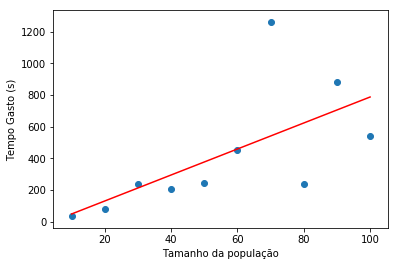

In [158]:
x = [10,20,30,40,50,60,70,80,90,100]
y = tempo_gasto

fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit)

plt.plot(x,fit_fn(x), color='r', )
plt.scatter(x,y)
plt.xlabel("Tamanho da população")
plt.ylabel("Tempo Gasto (s)")
plt.show()

#### Segundo teste - Crescimento da Taxa de Mutação

O segundo teste feito nessa seção visa avaliar a performance da solução a medida em que aumentamos a taxa de mutação. Para tal, iremos fixar todos os parâmetros usados na estratégia evolutiva e iremos variar a taxa de mutação entre 0 e 1. É importante ressaltar que a fim de avaliar exclusivamente a influência da mutação iremos considerar uma taxa de crossover igual a 0.Parâmetros usados: 
1. Tamanho da População &rarr; 10
2. Budget &rarr; 10.000
3. Delta &rarr; 0.01
4. Crossover &rarr; crossover2
    1. Taxa &rarr; 0.0
5. Mutação &rarr; mutation
    1. Taxa &rarr; variável de 0 a 1

In [187]:
population_size = 10
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 10
np_array = excels[5].values # Irá utilizar a primeira lista de valores da bolsa
crossover_rate = 0.0
chromossomes = create_population(population_size)

In [188]:
tempo_gasto_2 = []
i = 0.00
while i < 1.01:
    mutation_rate = i
    print("Testando taxa de: " + str(i))
    begin_time = time.time()
    temp = evolutionary_strategy2(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
    i = i + 0.10
    tempo_gasto_2.append(round(time.time() - begin_time, 2))
    print("\t Tempo gasto: " + str(round(time.time() - begin_time, 2)))

Testando taxa de: 0.0
	 Tempo gasto: 13.86
Testando taxa de: 0.1
	 Tempo gasto: 26.98
Testando taxa de: 0.2
	 Tempo gasto: 35.14
Testando taxa de: 0.30000000000000004
	 Tempo gasto: 22.74
Testando taxa de: 0.4
	 Tempo gasto: 44.51
Testando taxa de: 0.5
	 Tempo gasto: 42.04
Testando taxa de: 0.6
	 Tempo gasto: 30.33
Testando taxa de: 0.7
	 Tempo gasto: 31.43
Testando taxa de: 0.7999999999999999
	 Tempo gasto: 49.44
Testando taxa de: 0.8999999999999999
	 Tempo gasto: 35.41
Testando taxa de: 0.9999999999999999
	 Tempo gasto: 83.35


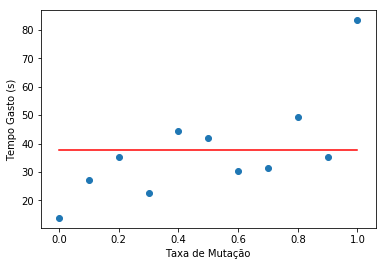

In [324]:
x_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_2 = tempo_gasto_2

fit = np.polyfit(x_2,y_2,0)
fit_fn = np.poly1d(fit)

plt.plot(x_2,fit_fn(x_2), color='r')
plt.scatter(x_2,y_2)
plt.xlabel("Taxa de Mutação")
plt.ylabel("Tempo Gasto (s)")
plt.show()

#### Terceiro teste - Crescimento da Taxa de Crossover

O terceiro teste feito nessa seção visa avaliar a performance da solução a medida em que aumentamos a taxa de crossover. Para tal, iremos fixar todos os parâmetros usados na estratégia evolutiva e iremos variar a taxa de crossover entre 0 e 1. É importante ressaltar que a fim de avaliar exclusivamente a influência do crossover iremos considerar uma taxa de mutação igual a 0. Parâmetros usados: 
1. Tamanho da População &rarr; 10
2. Budget &rarr; 10.000
3. Delta &rarr; 0.01
4. Crossover &rarr; crossover2
    1. Taxa &rarr; variável de 0 a 1
5. Mutação &rarr; mutation
    1. Taxa &rarr; 0

In [178]:
population_size = 10
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 10
np_array = excels[5].values # Irá utilizar a primeira lista de valores da bolsa
mutation_rate = 0.0
chromossomes = create_population(population_size)

In [179]:
tempo_gasto_3 = []
i = 0.00
while i < 1.01:
    crossover_rate = i
    print("Testando taxa de: " + str(i))
    begin_time = time.time()
    temp = evolutionary_strategy2(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
    i = i + 0.10
    tempo_gasto_3.append(round(time.time() - begin_time, 2))
    print("\t Tempo gasto: " + str(round(time.time() - begin_time, 2)))

Testando taxa de: 0.0
	 Tempo gasto: 13.57
Testando taxa de: 0.1
	 Tempo gasto: 15.77
Testando taxa de: 0.2
	 Tempo gasto: 16.25
Testando taxa de: 0.30000000000000004
	 Tempo gasto: 46.33
Testando taxa de: 0.4
	 Tempo gasto: 63.97
Testando taxa de: 0.5
	 Tempo gasto: 61.23
Testando taxa de: 0.6
	 Tempo gasto: 62.35
Testando taxa de: 0.7
	 Tempo gasto: 110.53
Testando taxa de: 0.7999999999999999
	 Tempo gasto: 64.76
Testando taxa de: 0.8999999999999999
	 Tempo gasto: 249.47
Testando taxa de: 0.9999999999999999
	 Tempo gasto: 474.93


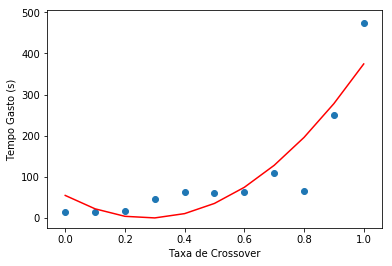

In [327]:
x_2 = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_3 = tempo_gasto_3

fit = np.polyfit(x_2,y_3,2)
fit_fn = np.poly1d(fit)

plt.plot(x_2,fit_fn(x_2), color='r')
plt.scatter(x_2,y_3)
plt.xlabel("Taxa de Crossover")
plt.ylabel("Tempo Gasto (s)")
plt.show()

### Testes simulando investimentos em Bitcoins

#### Teste usando o primeiro método de seleção

In [213]:
population_len = 100
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 3
np_array = excels[1].values # Irá utilizar a primeira lista de valores da bolsa
mutation_rate = 0.3
crossover_rate = 0.3
chromossomes = create_population(population_len)

In [215]:
begin_time = time.time()
best_chromossomes_bit = evolutionary_strategy1(np_array, chromossomes, budget, crossover2, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Tempo para convergir:  1599.8 segundos


In [217]:
fitness(np_array, best_chromossomes_bit, budget)

[[[0.022012803424865703, 3, 2, 195], 15.910772000000003],
 [[0.022012803424865703, 3, 2, 389], 15.910772000000003],
 [[0.09151269268100468, 25, 2, 110], 14.007738],
 [[0.09171406916728166, 25, 2, 395], 14.007738],
 [[0.022893235633398304, 5, 2, 308], 11.970265000000003],
 [[0.026988434437891763, 3, 2, 135], 11.869695000000002],
 [[0.017145640139993656, 25, 1, 469], 11.785234999999998],
 [[0.022893235633398304, 20, 6, 308], 11.702848],
 [[0.026988434437891763, 15, 2, 50], 11.635727999999997],
 [[0.026988434437891763, 15, 2, 135], 11.635727999999997],
 [[0.019330434581893544, 1, 2, 230], 10.552894000000004],
 [[0.08710053475918601, 13, 8, 77], 10.430105],
 [[0.026988434437891763, 20, 2, 135], 10.413548],
 [[0.018231753252271932, 12, 2, 118], 10.410480999999999],
 [[0.028774613921819854, 26, 6, 465], 10.375912],
 [[0.01987980047822622, 30, 7, 85], 10.335430000000002],
 [[0.018231753252271932, 30, 7, 118], 10.335430000000002],
 [[0.01987980047822622, 30, 7, 320], 10.335430000000002],
 [[0.

#### Teste usando o segundo método de seleção

In [218]:
population_len = 100
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 3
np_array = excels[1].values # Irá utilizar a primeira lista de valores da bolsa
mutation_rate = 0.3
crossover_rate = 0.3
chromossomes = create_population(population_len)

In [220]:
begin_time = time.time()
best_chromossomes_bit2 = evolutionary_strategy2(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Tempo para convergir:  4267.69 segundos


In [221]:
fitness(np_array, best_chromossomes_bit2, budget)

[[[0.08050241231600648, 12, 22, 359], 7.612497],
 [[0.032121642968961195, 9, 14, 153], 8.932965],
 [[0.042309670788088595, 12, 30, 442], 2.875233000000001],
 [[0.029560656646805697, 9, 15, 337], 2.5269999999999984],
 [[0.0038173919821788307, 9, 19, 494], 3.5529359999999985],
 [[0.06264418478554178, 9, 3, 422], 2.6500139999999983],
 [[0.013695633910672933, 14, 16, 102], 2.5473840000000005],
 [[0.08967797330357194, 6, 6, 71], 4.742458999999999],
 [[0.005143003898105048, 6, 19, 7], 3.444234000000001],
 [[0.014880357399341078, 23, 24, 356], 4.666202],
 [[0.057771091820190405, 28, 10, 399], 3.6916859999999994],
 [[0.057000383940422984, 15, 28, 97], 4.255996000000001],
 [[0.06554169601438845, 4, 17, 273], 5.437012],
 [[0.00422390275055694, 6, 5, 459], 2.617512999999996],
 [[0.09535249929640621, 18, 23, 457], 5.400450999999999],
 [[0.09535249929640621, 25, 4, 35], 9.032463],
 [[0.057000383940422984, 15, 12, 97], 4.1730220000000005],
 [[0.04075923146243861, 14, 25, 473], 3.2456680000000007],
 

#### Teste usando o segundo método de seleção sem normalizar a seleção

In [222]:
population_len = 100
budget = 10000
delta_to_converge = 0.01
min_iteration_converget = 3
np_array = excels[1].values # Irá utilizar a primeira lista de valores da bolsa
mutation_rate = 0.3
crossover_rate = 0.3
chromossomes = create_population(population_len)

In [224]:
begin_time = time.time()
best_chromossomes_bit3 = evolutionary_strategy2(np_array, chromossomes, budget, crossover2, mutation, delta_to_converge, mutation_rate, crossover_rate, min_iteration_converget)
print ("Tempo para convergir: ", round(time.time() - begin_time, 2), "segundos")

Tempo para convergir:  1500.62 segundos


In [226]:
fitness(np_array, best_chromossomes_bit3, budget)

[[[0.030407536148549387, 13, 6, 195], 3.3786829999999974],
 [[0.09328453823729199, 13, 7, 405], 4.2992919999999994],
 [[0.02868374856809726, 29, 14, 306], 2.0032490000000007],
 [[0.06821559776465158, 25, 2, 153], 2.539598999999999],
 [[0.05208319435449315, 20, 27, 421], 4.082082000000001],
 [[0.09196678143768322, 25, 14, 61], 4.352380999999999],
 [[0.016012925686858828, 21, 1, 96], 8.879861000000004],
 [[0.09450032484928146, 17, 16, 127], 3.6071420000000014],
 [[0.005464523327497018, 10, 15, 282], 3.9844019999999967],
 [[0.05617641151766252, 30, 15, 307], 5.589136],
 [[0.07627452443208593, 13, 24, 240], 2.403578],
 [[0.0749780294213502, 26, 26, 297], 1.9260079999999995],
 [[0.09196678143768322, 10, 1, 61], 9.150426000000001],
 [[0.09852201807476993, 9, 26, 455], 2.0873290000000004],
 [[0.09116238291674236, 21, 16, 26], 4.854342],
 [[0.005464523327497018, 29, 1, 282], 2.671789000000001],
 [[0.042252184197919124, 30, 18, 350], 3.5593799999999987],
 [[0.0864703280078245, 17, 24, 264], 5.0

### Análise do lucro ótimo

Iremos analisar quanto teríamos ganho se tivessemos comprado todas as ações no dia de menor valor e vendido no de maior

In [332]:
np_array = excels[5]
np_array.min()

Exchange Date    2017-05-01 00:00:00
Close                          96.93
Net                            -6.24
dtype: object

In [333]:
np_array.max()

Exchange Date    2019-04-30 00:00:00
Close                         139.92
Net                            13.46
dtype: object

In [344]:
compra = int(10000/(np_array["Close"].min()))
compra

103

In [343]:
sobra = 10000 % (np_array["Close"].min())
sobra

16.209999999999297

In [345]:
valor_venda = compra * np_array["Close"].max() + sobra
valor_venda

14427.969999999998

In [346]:
lucro = (valor_venda - 10000)/10000
lucro

0.4427969999999998